# Wav2vec 2.0 finetuning portuguese with Fairseq

Processar e salvar em uma pasta processed com train, val e test  

In [1]:
from datasets import load_dataset, load_metric
from datasets import load_from_disk
import argparse
from datasets import ClassLabel
import random
import pandas as pd
from IPython.display import display, HTML
import re
import json
import IPython.display as ipd
from IPython.display import Audio
import numpy as np
import random
import torchaudio
import librosa
import os
import json
import torch
import gc
from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from pytorch_lightning.loggers.neptune import NeptuneLogger

## Parameters

In [3]:
version = "wav2vec2_fairseq_target_librilabels_test1" #@param {type: "string"}
lr = 1e-4#@param {type: "number"}
w_decay = 0#@param {type: "number"}
bs = 5#@param {type: "integer"}
accum_grads = 4#@param {type: "integer"}
patience = 20#@param {type: "integer"}
max_epochs = 300#@param {type: "integer"}
# warmup_steps = 1000#@param {type: "integer"}
hold_epochs = 20#@param {type: "integer"}

# Define hyperparameters
hparams = {"version": version,
          "lr": lr,
          "w_decay": w_decay,
          "bs": bs,
          "patience": patience,
          "hold_epochs":hold_epochs,
          "accum_grads": accum_grads,
          "max_epochs": max_epochs}
hparams

{'version': 'wav2vec2_fairseq_target_librilabels_test1',
 'lr': 0.0001,
 'w_decay': 0,
 'bs': 5,
 'patience': 20,
 'hold_epochs': 20,
 'accum_grads': 4,
 'max_epochs': 300}

In [4]:
import fairseq
from fairseq.models.wav2vec.wav2vec2_asr import Wav2VecEncoder, Wav2VecCtc, Wav2Vec2AsrConfig, Wav2Vec2CtcConfig

In [5]:
# !mkdir models
# !wget https://dl.fbaipublicfiles.com/fairseq/wav2vec/xlsr_53_56k.pt
# !mv xlsr_53_56k.pt models

In [6]:
cp_path = './models/xlsr_53_56k.pt'
model, cfg, task = fairseq.checkpoint_utils.load_model_ensemble_and_task([cp_path])

model = model[0]
# model.eval()

# modelo tem 24 camadas transformers e embed_dim de 1024
print(model)
del model
gc.collect()
torch.cuda.empty_cache()

Wav2Vec2Model(
  (feature_extractor): ConvFeatureExtractionModel(
    (conv_layers): ModuleList(
      (0): Sequential(
        (0): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
        (1): Dropout(p=0.0, inplace=False)
        (2): Sequential(
          (0): TransposeLast()
          (1): Fp32LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (2): TransposeLast()
        )
        (3): GELU()
      )
      (1): Sequential(
        (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
        (1): Dropout(p=0.0, inplace=False)
        (2): Sequential(
          (0): TransposeLast()
          (1): Fp32LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (2): TransposeLast()
        )
        (3): GELU()
      )
      (2): Sequential(
        (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
        (1): Dropout(p=0.0, inplace=False)
        (2): Sequential(
          (0): TransposeLast()
          (1): Fp32LayerNorm((512,), eps=1e-05, elementwise_affine=True

In [7]:
class DictTable(dict):
    # Overridden dict class which takes a dict in the form {'a': 2, 'b': 3},
    # and renders an HTML Table in IPython Notebook.
    def _repr_html_(self):
        html = ["<table width=100%>"]
        for key, value in self.items():
            html.append("<tr>")
            html.append("<td>{0}</td>".format(key))
            html.append("<td>{0}</td>".format(value))
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)

In [8]:
cfg.keys()

dict_keys(['common', 'common_eval', 'distributed_training', 'dataset', 'optimization', 'checkpoint', 'bmuf', 'generation', 'eval_lm', 'interactive', 'model', 'task', 'criterion', 'optimizer', 'lr_scheduler', 'scoring', 'bpe', 'tokenizer'])

In [9]:
DictTable(cfg)

{'common': {'_name': None, 'no_progress_bar': False, 'log_interval': 500, 'log_format': 'json', 'tensorboard_logdir': None, 'wandb_project': None, 'seed': 1337, 'cpu': False, 'tpu': False, 'bf16': False, 'memory_efficient_bf16': False, 'fp16': True, 'memory_efficient_fp16': False, 'fp16_no_flatten_grads': False, 'fp16_init_scale': 128, 'fp16_scale_window': None, 'fp16_scale_tolerance': 0.0, 'min_loss_scale': 0.0001, 'threshold_loss_scale': None, 'user_dir': None, 'empty_cache_freq': 0, 'all_gather_list_size': 16384, 'model_parallel_size': 1, 'quantization_config_path': None, 'profile': False},
 'common_eval': {'_name': None, 'path': None, 'post_process': None, 'quiet': False, 'model_overrides': '{}', 'results_path': None},
 'distributed_training': {'_name': None, 'distributed_world_size': 128, 'distributed_rank': 0, 'distributed_backend': 'nccl', 'distributed_init_method': 'tcp://learnfair5044:30245', 'distributed_port': 30245, 'device_id': 0, 'local_rank': 0, 'distributed_no_spawn': True, 'ddp_backend': 'no_c10d', 'bucket_cap_mb': 25, 'fix_batches_to_gpus': False, 'find_unused_parameters': False, 'fast_stat_sync': False, 'broadcast_buffers': False, 'distributed_wrapper': 'DDP', 'slowmo_momentum': None, 'slowmo_algorithm': 'LocalSGD', 'localsgd_frequency': 3, 'nprocs_per_node': 8, 'pipeline_model_parallel': False, 'pipeline_balance': None, 'pipeline_devices': None, 'pipeline_chunks': 0, 'pipeline_encoder_balance': None, 'pipeline_encoder_devices': None, 'pipeline_decoder_balance': None, 'pipeline_decoder_devices': None, 'pipeline_checkpoint': 'never', 'zero_sharding': 'none', 'tpu': False},
 'dataset': {'_name': None, 'num_workers': 6, 'skip_invalid_size_inputs_valid_test': True, 'max_tokens': 1200000, 'batch_size': None, 'required_batch_size_multiple': 8, 'required_seq_len_multiple': 1, 'dataset_impl': None, 'data_buffer_size': 10, 'train_subset': 'train', 'valid_subset': 'valid', 'validate_interval': 5, 'validate_interval_updates': 10000, 'validate_after_updates': 0, 'fixed_validation_seed': None, 'disable_validation': False, 'max_tokens_valid': 1200000, 'batch_size_valid': None, 'curriculum': 0, 'gen_subset': 'test', 'num_shards': 1, 'shard_id': 0},
 'optimization': {'_name': None, 'max_epoch': 0, 'max_update': 1000000, 'stop_time_hours': 0.0, 'clip_norm': 0.0, 'sentence_avg': False, 'update_freq': [1], 'lr': [0.001], 'min_lr': -1.0, 'use_bmuf': False},
 'checkpoint': {'_name': None, 'save_dir': '/checkpoint/aconneau/asr/mls/53_300m_sweep_3.qtz.nrm.layer_norm.lnfrst.mlp768.lv320.lvb2.ab0.9_0.98.lr0.001.wu32000.mask10.mprob0.65.mstd0.ld0.0.drp_i0.0.drp_f0.0.fgm1.0.cb.pen0.1_0.mu1000000.s1337.ngpu128', 'restore_file': 'checkpoint_last.pt', 'finetune_from_model': None, 'reset_dataloader': False, 'reset_lr_scheduler': False, 'reset_meters': False, 'reset_optimizer': False, 'optimizer_overrides': '{}', 'save_interval': 1, 'save_interval_updates': 25000, 'keep_interval_updates': 1, 'keep_last_epochs': -1, 'keep_best_checkpoints': -1, 'no_save': False, 'no_epoch_checkpoints': True, 'no_last_checkpoints': False, 'no_save_optimizer_state': False, 'best_checkpoint_metric': 'loss', 'maximize_best_checkpoint_metric': False, 'patience': -1, 'checkpoint_suffix': '', 'checkpoint_shard_count': 1, 'model_parallel_size': 1, 'distributed_rank': 0},
 'bmuf': {'_name': None, 'block_lr': 1.0, 'block_momentum': 0.875, 'global_sync_iter': 50, 'warmup_iterations': 500, 'use_nbm': False, 'average_sync': False, 'distributed_world_size': 128},
 'generation': {'_name': None, 'beam': 5, 'nbest': 1, 'max_len_a': 0.0, 'max_len_b': 200, 'min_len': 1, 'match_source_len': False, 'unnormalized': False, 'no_early_stop': False, 'no_beamable_mm': False, 'lenpen': 1.0, 'unkpen': 0.0, 'replace_unk': None, 'sacrebleu': False, 'score_reference': False, 'prefix_size': 0, 'no_repeat_ngram_size': 0, 'sampling': False, 'sampling_topk': -1, 'sampling_topp': -1.0, 'constraints': None, 'temperature': 1.0, 'diverse_beam_groups': -1, 'diverse_beam_strength': 0.5, 'diversity_

In [10]:
DictTable(cfg['task'])

{'_name': 'audio_pretraining',
 'data': '/private/home/aconneau/projects/XLSR/MLS/53bis/',
 'labels': None,
 'sample_rate': 16000,
 'normalize': True,
 'enable_padding': False,
 'max_sample_size': 320000,
 'min_sample_size': 32000,
 'eval_wer': False,
 'eval_wer_config': {'_name': None, 'beam': 5, 'nbest': 1, 'max_len_a': 0.0, 'max_len_b': 200, 'min_len': 1, 'match_source_len': False, 'unnormalized': False, 'no_early_stop': False, 'no_beamable_mm': False, 'lenpen': 1.0, 'unkpen': 0.0, 'replace_unk': None, 'sacrebleu': False, 'score_reference': False, 'prefix_size': 0, 'no_repeat_ngram_size': 0, 'sampling': False, 'sampling_topk': -1, 'sampling_topp': -1.0, 'constraints': None, 'temperature': 1.0, 'diverse_beam_groups': -1, 'diverse_beam_strength': 0.5, 'diversity_rate': -1.0, 'print_alignment': 'hard', 'print_step': False, 'lm_path': None, 'lm_weight': 0.0, 'iter_decode_eos_penalty': 0.0, 'iter_decode_max_iter': 10, 'iter_decode_force_max_iter': False, 'iter_decode_with_beam': 1, 'iter_decode_with_external_reranker': False, 'retain_iter_history': False, 'retain_dropout': False, 'retain_dropout_modules': None, 'decoding_format': None, 'no_seed_provided': False},
 'eval_wer_tokenizer': None,
 'eval_wer_post_process': 'letter',
 'autoregressive': False}

In [11]:
DictTable(cfg['model'])

{'_name': 'wav2vec2',
 'extractor_mode': 'layer_norm',
 'encoder_layers': 24,
 'encoder_embed_dim': 1024,
 'encoder_ffn_embed_dim': 4096,
 'encoder_attention_heads': 16,
 'activation_fn': 'gelu',
 'dropout': 0.0,
 'attention_dropout': 0.0,
 'activation_dropout': 0.0,
 'encoder_layerdrop': 0.0,
 'dropout_input': 0.0,
 'dropout_features': 0.0,
 'final_dim': 768,
 'layer_norm_first': True,
 'conv_feature_layers': '[(512, 10, 5)] + [(512, 3, 2)] * 4 + [(512,2,2)] * 2',
 'conv_bias': True,
 'logit_temp': 0.1,
 'quantize_targets': True,
 'quantize_input': False,
 'same_quantizer': False,
 'target_glu': False,
 'feature_grad_mult': 1.0,
 'latent_vars': 320,
 'latent_groups': 2,
 'latent_dim': 0,
 'mask_length': 10,
 'mask_prob': 0.65,
 'mask_selection': 'static',
 'mask_other': 0.0,
 'no_mask_overlap': False,
 'mask_min_space': 1,
 'mask_channel_length': 10,
 'mask_channel_prob': 0.0,
 'mask_channel_selection': 'static',
 'mask_channel_other': 0.0,
 'no_mask_channel_overlap': False,
 'mask_channel_min_space': 1,
 'num_negatives': 100,
 'negatives_from_everywhere': False,
 'cross_sample_negatives': 0,
 'codebook_negatives': 0,
 'conv_pos': 128,
 'conv_pos_groups': 16,
 'latent_temp': [2.0, 0.1, 0.999995]}

In [12]:
print(cfg['task'])

print(cfg['task']['normalize'])

print(cfg['model'])

print(cfg['model']['conv_feature_layers'])

print(cfg['model']['encoder_embed_dim'])

{'_name': 'audio_pretraining', 'data': '/private/home/aconneau/projects/XLSR/MLS/53bis/', 'labels': None, 'sample_rate': 16000, 'normalize': True, 'enable_padding': False, 'max_sample_size': 320000, 'min_sample_size': 32000, 'eval_wer': False, 'eval_wer_config': {'_name': None, 'beam': 5, 'nbest': 1, 'max_len_a': 0.0, 'max_len_b': 200, 'min_len': 1, 'match_source_len': False, 'unnormalized': False, 'no_early_stop': False, 'no_beamable_mm': False, 'lenpen': 1.0, 'unkpen': 0.0, 'replace_unk': None, 'sacrebleu': False, 'score_reference': False, 'prefix_size': 0, 'no_repeat_ngram_size': 0, 'sampling': False, 'sampling_topk': -1, 'sampling_topp': -1.0, 'constraints': None, 'temperature': 1.0, 'diverse_beam_groups': -1, 'diverse_beam_strength': 0.5, 'diversity_rate': -1.0, 'print_alignment': 'hard', 'print_step': False, 'lm_path': None, 'lm_weight': 0.0, 'iter_decode_eos_penalty': 0.0, 'iter_decode_max_iter': 10, 'iter_decode_force_max_iter': False, 'iter_decode_with_beam': 1, 'iter_decode_w

In [13]:
wav2vec2asr_config = Wav2Vec2AsrConfig
# wav2vec2asr_config.w2v_path = './models/wav2vec_small.pt'
wav2vec2asr_config.w2v_path = './models/xlsr_53_56k.pt'
wav2vec2asr_config.normalize = True

wav2vec2asr_config.feature_grad_mult = 0
wav2vec2asr_config.apply_mask=True
wav2vec2asr_config.mask_prob=0.05
wav2vec2asr_config.mask_channel_prob=0.05
wav2vec2asr_config.layerdrop=0.01
wav2vec2asr_config.activation_dropout=0.01
wav2vec2asr_config.dropout=0.01
wav2vec2asr_config.attention_dropout=0.01
wav2vec2asr_config.final_dropout=0.01
wav2vec2asr_config.mask_length=10
wav2vec2asr_config.mask_channel_length=10

# parameters used in base_960h.yaml
# wav2vec2asr_config.feature_grad_mult = 0
# wav2vec2asr_config.apply_mask=True
# wav2vec2asr_config.mask_prob=0.5
# wav2vec2asr_config.mask_channel_prob=0.1
# wav2vec2asr_config.mask_channel_length=64
# wav2vec2asr_config.layerdrop=0.1
# wav2vec2asr_config.activation_dropout=0.1

# wav2vec2asr_config.feature_grad_mult = 0
# wav2vec2asr_config.apply_mask=True
# wav2vec2asr_config.mask_prob=0.01
# # wav2vec2asr_config.mask_channel_prob=0.05
# wav2vec2asr_config.layerdrop=0.01
# wav2vec2asr_config.activation_dropout=0.01

# no mask
# wav2vec2asr_config.feature_grad_mult = 0
# wav2vec2asr_config.layerdrop=0.1
# wav2vec2asr_config.activation_dropout=0.1


print("normalize:", wav2vec2asr_config.normalize)

wav2vec2ctc_config = Wav2Vec2CtcConfig
wav2vec2ctc_config.w2v_path = './models/xlsr_53_56k.pt'
wav2vec2ctc_config.normalize = cfg['task']['normalize']
wav2vec2ctc_config.conv_feature_layers = cfg['model']['conv_feature_layers']
wav2vec2ctc_config.encoder_embed_dim = cfg['model']['encoder_embed_dim']
print(wav2vec2ctc_config.w2v_args)


# wav2vec2ctc_config.feature_grad_mult = 0
# wav2vec2ctc_config.apply_mask=True
# wav2vec2ctc_config.mask_prob=0.5
# wav2vec2ctc_config.mask_channel_prob=0.1
# wav2vec2ctc_config.mask_channel_length=64
# wav2vec2ctc_config.layerdrop=0.1
# wav2vec2ctc_config.activation_dropout=0.1

# wav2vec2ctc_config.feature_grad_mult = 0
# wav2vec2ctc_config.apply_mask=True
# wav2vec2ctc_config.mask_prob=0.05
# wav2vec2ctc_config.mask_channel_prob=0.1
# wav2vec2ctc_config.layerdrop=0.1
# wav2vec2ctc_config.activation_dropout=0.1

normalize: True
None


In [14]:
DictTable(vars(wav2vec2asr_config))

{'__module__': 'fairseq.models.wav2vec.wav2vec2_asr',
 '__annotations__': {'w2v_path': str,
  'no_pretrained_weights': bool,
  'dropout_input': float,
  'final_dropout': float,
  'dropout': float,
  'attention_dropout': float,
  'activation_dropout': float,
  'apply_mask': bool,
  'mask_length': int,
  'mask_prob': float,
  'mask_selection': <enum 'Choices'>,
  'mask_other': float,
  'no_mask_overlap': bool,
  'mask_channel_length': int,
  'mask_channel_prob': float,
  'mask_channel_selection': <enum 'Choices'>,
  'mask_channel_other': float,
  'no_mask_channel_overlap': bool,
  'freeze_finetune_updates': int,
  'feature_grad_mult': float,
  'layerdrop': float,
  'mask_channel_before': bool,
  'normalize': bool,
  'data': str,
  'w2v_args': typing.Any},
 'w2v_path': './models/xlsr_53_56k.pt',
 'no_pretrained_weights': False,
 'dropout_input': 0.0,
 'final_dropout': 0.01,
 'dropout': 0.01,
 'attention_dropout': 0.01,
 'activation_dropout': 0.01,
 'apply_mask': True,
 'mask_length': 10,
 'mask_prob': 0.05,
 'mask_selection': 'static',
 'mask_other': 0,
 'no_mask_overlap': False,
 'mask_channel_length': 10,
 'mask_channel_prob': 0.05,
 'mask_channel_selection': 'static',
 'mask_channel_other': 0,
 'no_mask_channel_overlap': False,
 'freeze_finetune_updates': 0,
 'feature_grad_mult': 0,
 'layerdrop': 0.01,
 'mask_channel_before': False,
 'normalize': True,
 'data': '${task.data}',
 'w2v_args': None,
 '__doc__': "Wav2Vec2AsrConfig(_name: Union[str, NoneType] = None, w2v_path: str = '???', no_pretrained_weights: bool = False, dropout_input: float = 0.0, final_dropout: float = 0.0, dropout: float = 0.0, attention_dropout: float = 0.0, activation_dropout: float = 0.0, apply_mask: bool = False, mask_length: int = 10, mask_prob: float = 0.5, mask_selection: fairseq.dataclass.constants.Choices = 'static', mask_other: float = 0, no_mask_overlap: bool = False, mask_channel_length: int = 10, mask_channel_prob: float = 0.0, mask_channel_selection: fairseq.dataclass.constants.Choices = 'static', mask_channel_other: float = 0, no_mask_channel_overlap: bool = False, freeze_finetune_updates: int = 0, feature_grad_mult: float = 0.0, layerdrop: float = 0.0, mask_channel_before: bool = False, normalize: bool = '${task.normalize}', data: str = '${task.data}', w2v_args: Any = None)",
 '__dataclass_params__': _DataclassParams(init=True,repr=True,eq=True,order=False,unsafe_hash=False,frozen=False),
 '__dataclass_fields__': {'_name': Field(name='_name',type=typing.Union[str, NoneType],default=None,default_factory=<dataclasses._MISSING_TYPE object at 0x7fbf000733d0>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),_field_type=_FIELD),
  'w2v_path': Field(name='w2v_path',type=<class 'str'>,default='???',default_factory=<dataclasses._MISSING_TYPE object at 0x7fbf000733d0>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({'help': 'path to wav2vec 2.0 model'}),_field_type=_FIELD),
  'no_pretrained_weights': Field(name='no_pretrained_weights',type=<class 'bool'>,default=False,default_factory=<dataclasses._MISSING_TYPE object at 0x7fbf000733d0>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({'help': 'if true, does not load pretrained weights'}),_field_type=_FIELD),
  'dropout_input': Field(name='dropout_input',type=<class 'float'>,default=0.0,default_factory=<dataclasses._MISSING_TYPE object at 0x7fbf000733d0>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({'help': 'dropout to apply to the input (after feat extr)'}),_field_type=_FIELD),
  'final_dropout': Field(name='final_dropout',type=<class 'float'>,default=0.0,default_factory=<dataclasses._MISSING_TYPE object at 0x7fbf000733d0>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({'help': 'dropout after transformer and before final projection'}),_field_type=_FIELD),
  'dropout': Field(name='dropout',type=<class 'float'>,default=0.0,default_factory=<dataclasses._MISSING_TYPE object at 0x7fbf000733d0>,init=True,repr=True,hash

In [15]:
DictTable(vars(wav2vec2ctc_config))

{'__module__': 'fairseq.models.wav2vec.wav2vec2_asr',
 '__annotations__': {'blank_weight': float,
  'blank_mode': str,
  'mask_min_space': typing.Union[int, NoneType],
  'mask_channel_min_space': typing.Union[int, NoneType],
  'conv_feature_layers': typing.Union[str, NoneType],
  'encoder_embed_dim': typing.Union[int, NoneType]},
 'blank_weight': 0,
 'blank_mode': 'add',
 'mask_min_space': 1,
 'mask_channel_min_space': 1,
 'conv_feature_layers': '[(512, 10, 5)] + [(512, 3, 2)] * 4 + [(512,2,2)] * 2',
 'encoder_embed_dim': 1024,
 '__doc__': "Wav2Vec2CtcConfig(_name: Union[str, NoneType] = None, w2v_path: str = '???', no_pretrained_weights: bool = False, dropout_input: float = 0.0, final_dropout: float = 0.0, dropout: float = 0.0, attention_dropout: float = 0.0, activation_dropout: float = 0.0, apply_mask: bool = False, mask_length: int = 10, mask_prob: float = 0.5, mask_selection: fairseq.dataclass.constants.Choices = 'static', mask_other: float = 0, no_mask_overlap: bool = False, mask_channel_length: int = 10, mask_channel_prob: float = 0.0, mask_channel_selection: fairseq.dataclass.constants.Choices = 'static', mask_channel_other: float = 0, no_mask_channel_overlap: bool = False, freeze_finetune_updates: int = 0, feature_grad_mult: float = 0.0, layerdrop: float = 0.0, mask_channel_before: bool = False, normalize: bool = '${task.normalize}', data: str = '${task.data}', w2v_args: Any = None, blank_weight: float = 0, blank_mode: str = 'add', mask_min_space: Union[int, NoneType] = 1, mask_channel_min_space: Union[int, NoneType] = 1, conv_feature_layers: Union[str, NoneType] = '[(512, 10, 5)] + [(512, 3, 2)] * 4 + [(512,2,2)] + [(512,2,2)]', encoder_embed_dim: Union[int, NoneType] = 768)",
 '__dataclass_params__': _DataclassParams(init=True,repr=True,eq=True,order=False,unsafe_hash=False,frozen=False),
 '__dataclass_fields__': {'_name': Field(name='_name',type=typing.Union[str, NoneType],default=None,default_factory=<dataclasses._MISSING_TYPE object at 0x7fbf000733d0>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),_field_type=_FIELD),
  'w2v_path': Field(name='w2v_path',type=<class 'str'>,default='???',default_factory=<dataclasses._MISSING_TYPE object at 0x7fbf000733d0>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({'help': 'path to wav2vec 2.0 model'}),_field_type=_FIELD),
  'no_pretrained_weights': Field(name='no_pretrained_weights',type=<class 'bool'>,default=False,default_factory=<dataclasses._MISSING_TYPE object at 0x7fbf000733d0>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({'help': 'if true, does not load pretrained weights'}),_field_type=_FIELD),
  'dropout_input': Field(name='dropout_input',type=<class 'float'>,default=0.0,default_factory=<dataclasses._MISSING_TYPE object at 0x7fbf000733d0>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({'help': 'dropout to apply to the input (after feat extr)'}),_field_type=_FIELD),
  'final_dropout': Field(name='final_dropout',type=<class 'float'>,default=0.0,default_factory=<dataclasses._MISSING_TYPE object at 0x7fbf000733d0>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({'help': 'dropout after transformer and before final projection'}),_field_type=_FIELD),
  'dropout': Field(name='dropout',type=<class 'float'>,default=0.0,default_factory=<dataclasses._MISSING_TYPE object at 0x7fbf000733d0>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({'help': 'dropout probability inside wav2vec 2.0 model'}),_field_type=_FIELD),
  'attention_dropout': Field(name='attention_dropout',type=<class 'float'>,default=0.0,default_factory=<dataclasses._MISSING_TYPE object at 0x7fbf000733d0>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({'help': 'dropout probability for attention weights inside wav2vec 2.0 model'}),_field_type=_FIELD),
  'activation_dropout': Field(name='activation_dropout',type=<class 'float'>,default=0.0,default_factory=<dataclasses._MISSING_TYPE object at 0x

In [16]:
from fairseq.criterions.ctc import CtcCriterion, CtcCriterionConfig

In [17]:
ctc_config = CtcCriterionConfig

In [18]:
DictTable(vars(ctc_config))

{'__module__': 'fairseq.criterions.ctc',
 '__annotations__': {'zero_infinity': bool,
  'sentence_avg': bool,
  'post_process': str,
  'wer_kenlm_model': typing.Union[str, NoneType],
  'wer_lexicon': typing.Union[str, NoneType],
  'wer_lm_weight': float,
  'wer_word_score': float,
  'wer_args': typing.Union[str, NoneType]},
 'zero_infinity': False,
 'sentence_avg': '${optimization.sentence_avg}',
 'post_process': 'letter',
 'wer_kenlm_model': None,
 'wer_lexicon': None,
 'wer_lm_weight': 2.0,
 'wer_word_score': -1.0,
 'wer_args': None,
 '__doc__': "CtcCriterionConfig(_name: Union[str, NoneType] = None, zero_infinity: bool = False, sentence_avg: bool = '${optimization.sentence_avg}', post_process: str = 'letter', wer_kenlm_model: Union[str, NoneType] = None, wer_lexicon: Union[str, NoneType] = None, wer_lm_weight: float = 2.0, wer_word_score: float = -1.0, wer_args: Union[str, NoneType] = None)",
 '__dataclass_params__': _DataclassParams(init=True,repr=True,eq=True,order=False,unsafe_hash=False,frozen=False),
 '__dataclass_fields__': {'_name': Field(name='_name',type=typing.Union[str, NoneType],default=None,default_factory=<dataclasses._MISSING_TYPE object at 0x7fbf000733d0>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),_field_type=_FIELD),
  'zero_infinity': Field(name='zero_infinity',type=<class 'bool'>,default=False,default_factory=<dataclasses._MISSING_TYPE object at 0x7fbf000733d0>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({'help': 'zero inf loss when source length <= target length'}),_field_type=_FIELD),
  'sentence_avg': Field(name='sentence_avg',type=<class 'bool'>,default='${optimization.sentence_avg}',default_factory=<dataclasses._MISSING_TYPE object at 0x7fbf000733d0>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({}),_field_type=_FIELD),
  'post_process': Field(name='post_process',type=<class 'str'>,default='letter',default_factory=<dataclasses._MISSING_TYPE object at 0x7fbf000733d0>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({'help': 'how to post process predictions into words. can be letter, wordpiece, BPE symbols, etc. See fairseq.data.data_utils.post_process() for full list of options'}),_field_type=_FIELD),
  'wer_kenlm_model': Field(name='wer_kenlm_model',type=typing.Union[str, NoneType],default=None,default_factory=<dataclasses._MISSING_TYPE object at 0x7fbf000733d0>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({'help': 'if this is provided, use kenlm to compute wer (along with other wer_* args)'}),_field_type=_FIELD),
  'wer_lexicon': Field(name='wer_lexicon',type=typing.Union[str, NoneType],default=None,default_factory=<dataclasses._MISSING_TYPE object at 0x7fbf000733d0>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({'help': 'lexicon to use with wer_kenlm_model'}),_field_type=_FIELD),
  'wer_lm_weight': Field(name='wer_lm_weight',type=<class 'float'>,default=2.0,default_factory=<dataclasses._MISSING_TYPE object at 0x7fbf000733d0>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({'help': 'lm weight to use with wer_kenlm_model'}),_field_type=_FIELD),
  'wer_word_score': Field(name='wer_word_score',type=<class 'float'>,default=-1.0,default_factory=<dataclasses._MISSING_TYPE object at 0x7fbf000733d0>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({'help': 'lm word score to use with wer_kenlm_model'}),_field_type=_FIELD),
  'wer_args': Field(name='wer_args',type=typing.Union[str, NoneType],default=None,default_factory=<dataclasses._MISSING_TYPE object at 0x7fbf000733d0>,init=True,repr=True,hash=None,compare=True,metadata=mappingproxy({'help': 'DEPRECATED: tuple of (wer_kenlm_model, wer_lexicon, wer_lm_weight, wer_word_score)'}),_field_type=_FIELD)},
 '__init__': <function fairseq.criterions.ctc.__create_fn__.<locals>.__init__(self, _name: Union[str, NoneType] = None, zero_infinity: bool = False, sentence_avg: bool = '${optimization.sentence_avg}', post_proc

In [19]:
def speech_file_to_array_fn(batch):
  speech_array, sampling_rate = torchaudio.load(batch["path"])
  
  # batch["speech"] = speech_array[0].numpy()
  np.save(batch["path"][:-4] + '.npy', speech_array[0].numpy())
  
  batch["speech"] = batch["path"][:-4] + '.npy'
  batch["sampling_rate"] = sampling_rate
  batch["target_text"] = batch["sentence"]
  del speech_array
  gc.collect()
  return batch

def resample(batch):
  # batch["speech"] = librosa.resample(np.asarray(batch["speech"]), 48_000, 16_000)
  batch["speech"] = librosa.resample(np.array(np.load(batch["speech"])), 48_000, 16_000)
  batch["sampling_rate"] = 16_000
  return batch

def show_random_elements(dataset, num_examples=10):
  assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
  picks = []
  for _ in range(num_examples):
      pick = random.randint(0, len(dataset)-1)
      while pick in picks:
          pick = random.randint(0, len(dataset)-1)
      picks.append(pick)

  df = pd.DataFrame(dataset[picks])
  print(df)
  # display(HTML(df.to_html()))

def extract_all_chars(batch):
  all_text = " ".join(batch["sentence"])
  vocab = list(set(all_text))
  return {"vocab": [vocab], "all_text": [all_text]}

def remove_special_characters(batch):
  batch["sentence"] = re.sub(chars_to_ignore_regex, '', batch["sentence"]).lower() + " "
  return batch

def libri_labels(batch):
  batch["sentence"] = " ".join(list(batch["sentence"].replace(" ", "|"))) + " |"
  return batch  

## Preprocessed dataset?

In [20]:
# preprocesseds = False
preprocesseds = all([os.path.isdir('preprocessed_fairseq/train')]) 
print(preprocesseds)

True


In [21]:
if not preprocesseds:
  dataset = load_dataset("common_voice", "pt", split="train+validation")
  
  dataset = dataset.train_test_split(test_size=0.1)
  
  common_voice_train = dataset['train']
  common_voice_val = dataset['test']

  common_voice_test = load_dataset("common_voice", "pt", split="test")

  columns_to_remove = ["accent", "age", "client_id", "down_votes", "gender", "locale", "segment", "up_votes"]

  common_voice_train = common_voice_train.remove_columns(columns_to_remove)
  common_voice_val = common_voice_val.remove_columns(columns_to_remove)
  common_voice_test = common_voice_test.remove_columns(columns_to_remove)

In [22]:
if not preprocesseds:
  show_random_elements(common_voice_train)

In [23]:
# if not preprocesseds:
#   common_voice_train = common_voice_train.select(np.arange(1000))
#   common_voice_val = common_voice_val.select(np.arange(1000))
#   common_voice_test = common_voice_test.select(np.arange(1000))

#   print(common_voice_train)
#   print(common_voice_val)
#   print(common_voice_test)

In [24]:
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"\“\%\‘\”\�]'

if not preprocesseds:
  common_voice_train = common_voice_train.map(remove_special_characters)
  common_voice_val = common_voice_val.map(remove_special_characters)
  common_voice_test = common_voice_test.map(remove_special_characters)

  show_random_elements(common_voice_train)

In [25]:
if not preprocesseds:
  common_voice_train = common_voice_train.map(libri_labels)
  common_voice_val = common_voice_val.map(libri_labels)
  common_voice_test = common_voice_test.map(libri_labels)

  show_random_elements(common_voice_train)

In [26]:
# !mkdir preprocessed_fairseq

In [27]:
if not preprocesseds:
  common_voice_train = common_voice_train.map(speech_file_to_array_fn,
                                              remove_columns=common_voice_train.column_names)
  common_voice_val = common_voice_val.map(speech_file_to_array_fn,
                                            remove_columns=common_voice_test.column_names)
  common_voice_test = common_voice_test.map(speech_file_to_array_fn,
                                            remove_columns=common_voice_test.column_names)

In [28]:
if not preprocesseds:
  common_voice_train = common_voice_train.map(resample, num_proc=1)
  common_voice_val = common_voice_val.map(resample, num_proc=1)
  common_voice_test = common_voice_test.map(resample, num_proc=1)

In [29]:
if not preprocesseds:
  common_voice_train.save_to_disk("preprocessed_fairseq/train")
  common_voice_val.save_to_disk("preprocessed_fairseq/val")
  common_voice_test.save_to_disk("preprocessed_fairseq/test")

In [30]:
if preprocesseds:
  common_voice_train = load_from_disk("preprocessed_fairseq/train")
  common_voice_val = load_from_disk("preprocessed_fairseq/val")
  common_voice_test = load_from_disk("preprocessed_fairseq/test")

In [31]:
print(common_voice_train)
print(common_voice_train[0])

Dataset({
    features: ['sampling_rate', 'speech', 'target_text'],
    num_rows: 9995
})
{'sampling_rate': 16000, 'speech': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [32]:
print(common_voice_val)
print(common_voice_val[0])

Dataset({
    features: ['sampling_rate', 'speech', 'target_text'],
    num_rows: 1111
})
{'sampling_rate': 16000, 'speech': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.164752690938758e-16, 3.4536487286961374e-16, -2.3942095644236125e-15, 7.060254243490983e-15, -1.5961658264649486e-14, 3.108684777696283e-14, -5.462105512896512e-14, 8.861922290827676e-14, -1.3449696001019418e-13, 1.9232627101149757e-13, -2.5994630710110544e-13, 3.319298774642071e-13, -3.968266145369659e-13, 4.405976993838989e-13, -4.4016342220370985e-13, 3.6800670475366226e-13, -1.8965912011465608e-13, -1.3363379955562416e-13, 6.418298509856812e-13, -1.3746432377809148e-12, 2.3640898266785726e-12, -3.6298900083636676e-12, 5.173517430429042e-12, -6.965170627759587e-12, 8.945681001515382e-12, -1.1012846017066646e-11, 1.3019925415580502e-11, -1.4773208698026785e-11, 1.603360846869073e-11, -1.652174404231932e-11, 1.5932611133195884e-11, -1.394450267061531e-11, 1.0246452991635735e-

In [33]:
print(common_voice_test)
print(common_voice_test[0])

Dataset({
    features: ['sampling_rate', 'speech', 'target_text'],
    num_rows: 4641
})
{'sampling_rate': 16000, 'speech': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

# Datasets and Dataloaders

In [34]:
neptune_logger = NeptuneLogger(
    api_key="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjMmJkZTg1Yy1kMjQ1LTRmMjEtYjBmYy1kMjVlMmMxODcyMTgifQ==",
    project_name='orllem/Wav2vec2')

NeptuneLogger will work in online mode


In [35]:
def show_batch(dataset, num_examples=10):
    """ Show a batch of 10 random audios from a dataset.
    """
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df_data = []
    for pick in picks:
      dic_data = {}
      dic_data["source"] = dataset[pick]["source"].detach().cpu().numpy()
      dic_data["label"] = dataset[pick]["label"].detach().cpu().numpy()
      # print(dic_data["source"])
      # print(dic_data["label"])
      df_data.append(dic_data)
    #[dataset[pick] for pick in picks]
    # print(df_data)
    df = pd.DataFrame(df_data)
    display(HTML(df.to_html()))

In [36]:
from fairseq.data.audio.raw_audio_dataset import RawAudioDataset
from fairseq.tasks.audio_pretraining import AudioPretrainingTask, AudioPretrainingConfig
from fairseq.dataclass import FairseqDataclass
from fairseq.data import (
    AddTargetDataset,
    BinarizedAudioDataset,
    Dictionary,
    FileAudioDataset,
    encoders,
)

In [37]:
class AudioDataset(RawAudioDataset):

  def __init__(
        self,
        data,
        split,
        sample_rate,
        max_sample_size=None,
        min_sample_size=0,
        shuffle=True,
        pad=False,
        normalize=False,
        num_buckets=0,
        compute_mask_indices=False,
        **mask_compute_kwargs,
    ):
        super().__init__(
            sample_rate=sample_rate,
            max_sample_size=max_sample_size,
            min_sample_size=min_sample_size,
            shuffle=shuffle,
            pad=pad,
            normalize=normalize,
            compute_mask_indices=compute_mask_indices,
            **mask_compute_kwargs,
        )
        self.data = data

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    
    wav = self.data[index]["speech"]
    feats = torch.from_numpy(np.asarray(wav)).float()
    feats = self.postprocess(feats, curr_sample_rate=self.data[index]["sampling_rate"])
    return {"id": index, "source": feats}

In [38]:
class LabelEncoder(object):
    def __init__(self, dictionary):
        self.dictionary = dictionary

    def __call__(self, label):
        return self.dictionary.encode_line(
            label,
            append_eos=False,
            add_if_not_exist=False
        )

class AudioFinetuneTask(AudioPretrainingTask):
  def __init__(
        self,
        cfg: AudioPretrainingConfig,
    ):
        super().__init__(cfg)

  def load_dataset(self, data, split: str, task_cfg: FairseqDataclass = None, **kwargs):
        task_cfg = task_cfg or self.cfg

        self.datasets[split] = AudioDataset(
            data,
            split=split,
            sample_rate=task_cfg.get("sample_rate", self.cfg.sample_rate),
            max_sample_size=self.cfg.max_sample_size,
            min_sample_size=self.cfg.min_sample_size,
            pad=task_cfg.labels is not None or task_cfg.enable_padding,
            normalize=task_cfg.normalize,
        )
      
        process_label = LabelEncoder(self.target_dictionary)

        self.datasets[split] = AddTargetDataset(
            dataset=self.datasets[split],
            labels=data["target_text"],
            pad=self.target_dictionary.pad(),
            eos=self.target_dictionary.eos(),
            batch_targets=True,
            process_label=process_label,
            # add_to_input=task_cfg.get("autoregressive", False),
        )      

In [39]:
from fairseq.tasks import FairseqTask
from fairseq.data.data_utils import post_process

In [40]:
import torch.nn.functional as F
from fairseq import metrics, utils

class CtcCriterionFinetuning(CtcCriterion):
  def __init__(self, cfg: CtcCriterionConfig, task: FairseqTask):
    super().__init__(cfg, task)
  
  def batch_decode(self, targets):
    target_sentences = list()
    with torch.no_grad():
      for t in targets:
        # print('t', t)
        p = (t != self.task.target_dictionary.pad()) & (t != self.task.target_dictionary.eos())
        targ = t[p]
        targ_units = self.task.target_dictionary.string(targ)
        # print(targ_units)

        targ_words = post_process(targ_units, self.post_process)  
        target_sentences.append(targ_words)
    return target_sentences   
  
  def batch_decode_pred(self, model, sample, reduce=True):
    net_output = model(**sample["net_input"])
    lprobs = model.get_normalized_probs(
        net_output, log_probs=True
    ).contiguous()  # (T, B, C) from the encoder

    if "src_lengths" in sample["net_input"]:
        input_lengths = sample["net_input"]["src_lengths"]
    else:
        if net_output["padding_mask"] is not None:
            non_padding_mask = ~net_output["padding_mask"]
            input_lengths = non_padding_mask.long().sum(-1)
        else:
            input_lengths = lprobs.new_full(
                (lprobs.size(1),), lprobs.size(0), dtype=torch.long
            )

    if not model.training:

        with torch.no_grad():
            lprobs_t = lprobs.transpose(0, 1).float().contiguous().cpu()

            pred_lp_words = []
            for lp, t, inp_l in zip(
                lprobs_t,
                sample["target_label"]
                if "target_label" in sample
                else sample["target"],
                input_lengths,
            ):
                lp = lp[:inp_l].unsqueeze(0)

                toks = lp.argmax(dim=-1).unique_consecutive()
                pred_units_arr = toks[toks != self.blank_idx].tolist()

                pred_units = self.task.target_dictionary.string(pred_units_arr)
                pred_words = post_process(pred_units, self.post_process)
                pred_lp_words.append(pred_words)

    return pred_lp_words 

In [41]:
# print(cfg['task'].enable_padding) 

cfg['task'].enable_padding = True

print('enable_padding:', cfg['task'].enable_padding)

cfg['task'].eval_wer = True

print('eval_wer:', cfg['task'].eval_wer) 

cfg['task'].labels = 'keys'

print('labels:', cfg['task'].labels) 

finetune_task = AudioFinetuneTask(cfg=cfg['task'])

finetune_task.cfg.data = 'data'
# finetune_task.cfg.labels = 'keys'
print(finetune_task.cfg.labels)

enable_padding: True
eval_wer: True
labels: keys
keys


In [42]:
fname = 'data/dict.keys.txt'

with open(fname, 'r') as f:
  file_contents = f.read()
  print(file_contents)
  f.close()

| 133723
a 67556
e 65594
o 58743
s 40616
r 35399
m 30645
i 29812
n 28644
u 26889
d 25443
t 24929
c 19860
l 15870
p 14652
v 9367
h 7394
g 6469
b 5723
f 5564
q 5155
ã 4744
á 3441
é 2771
ç 2416
ê 2233
z 2116
j 1878
x 1138
ó 943
í 900
ú 414
õ 307
k 288
à 249
y 244
w 207
ô 187
â 179
ü 12
' 11
ñ 1



In [43]:
DictTable(vars(finetune_task))

{'cfg': {'_name': 'audio_pretraining', 'data': 'data', 'labels': 'keys', 'sample_rate': 16000, 'normalize': True, 'enable_padding': True, 'max_sample_size': 320000, 'min_sample_size': 32000, 'eval_wer': True, 'eval_wer_config': {'_name': None, 'beam': 5, 'nbest': 1, 'max_len_a': 0.0, 'max_len_b': 200, 'min_len': 1, 'match_source_len': False, 'unnormalized': False, 'no_early_stop': False, 'no_beamable_mm': False, 'lenpen': 1.0, 'unkpen': 0.0, 'replace_unk': None, 'sacrebleu': False, 'score_reference': False, 'prefix_size': 0, 'no_repeat_ngram_size': 0, 'sampling': False, 'sampling_topk': -1, 'sampling_topp': -1.0, 'constraints': None, 'temperature': 1.0, 'diverse_beam_groups': -1, 'diverse_beam_strength': 0.5, 'diversity_rate': -1.0, 'print_alignment': 'hard', 'print_step': False, 'lm_path': None, 'lm_weight': 0.0, 'iter_decode_eos_penalty': 0.0, 'iter_decode_max_iter': 10, 'iter_decode_force_max_iter': False, 'iter_decode_with_beam': 1, 'iter_decode_with_external_reranker': False, 'retain_iter_history': False, 'retain_dropout': False, 'retain_dropout_modules': None, 'decoding_format': None, 'no_seed_provided': False}, 'eval_wer_tokenizer': None, 'eval_wer_post_process': 'letter', 'autoregressive': False},
 'datasets': {},
 'dataset_to_epoch_iter': {},
 'state': <fairseq.tasks.fairseq_task.StatefulContainer at 0x7fbd60258a90>,
 'blank_symbol': '<s>'}

In [44]:
DictTable(finetune_task.cfg)
# print(finetune_task.cfg)

{'_name': 'audio_pretraining',
 'data': 'data',
 'labels': 'keys',
 'sample_rate': 16000,
 'normalize': True,
 'enable_padding': True,
 'max_sample_size': 320000,
 'min_sample_size': 32000,
 'eval_wer': True,
 'eval_wer_config': {'_name': None, 'beam': 5, 'nbest': 1, 'max_len_a': 0.0, 'max_len_b': 200, 'min_len': 1, 'match_source_len': False, 'unnormalized': False, 'no_early_stop': False, 'no_beamable_mm': False, 'lenpen': 1.0, 'unkpen': 0.0, 'replace_unk': None, 'sacrebleu': False, 'score_reference': False, 'prefix_size': 0, 'no_repeat_ngram_size': 0, 'sampling': False, 'sampling_topk': -1, 'sampling_topp': -1.0, 'constraints': None, 'temperature': 1.0, 'diverse_beam_groups': -1, 'diverse_beam_strength': 0.5, 'diversity_rate': -1.0, 'print_alignment': 'hard', 'print_step': False, 'lm_path': None, 'lm_weight': 0.0, 'iter_decode_eos_penalty': 0.0, 'iter_decode_max_iter': 10, 'iter_decode_force_max_iter': False, 'iter_decode_with_beam': 1, 'iter_decode_with_external_reranker': False, 'retain_iter_history': False, 'retain_dropout': False, 'retain_dropout_modules': None, 'decoding_format': None, 'no_seed_provided': False},
 'eval_wer_tokenizer': None,
 'eval_wer_post_process': 'letter',
 'autoregressive': False}

In [45]:
finetune_task.state.target_dictionary = finetune_task.load_target_dictionary()
print(finetune_task.target_dictionary.symbols)

print(finetune_task.target_dictionary.indices)

task_dict = finetune_task.target_dictionary.indices

print(len(task_dict))

['<s>', '<pad>', '</s>', '<unk>', '|', 'a', 'e', 'o', 's', 'r', 'm', 'i', 'n', 'u', 'd', 't', 'c', 'l', 'p', 'v', 'h', 'g', 'b', 'f', 'q', 'ã', 'á', 'é', 'ç', 'ê', 'z', 'j', 'x', 'ó', 'í', 'ú', 'õ', 'k', 'à', 'y', 'w', 'ô', 'â', 'ü', "'", 'ñ']
{'<s>': 0, '<pad>': 1, '</s>': 2, '<unk>': 3, '|': 4, 'a': 5, 'e': 6, 'o': 7, 's': 8, 'r': 9, 'm': 10, 'i': 11, 'n': 12, 'u': 13, 'd': 14, 't': 15, 'c': 16, 'l': 17, 'p': 18, 'v': 19, 'h': 20, 'g': 21, 'b': 22, 'f': 23, 'q': 24, 'ã': 25, 'á': 26, 'é': 27, 'ç': 28, 'ê': 29, 'z': 30, 'j': 31, 'x': 32, 'ó': 33, 'í': 34, 'ú': 35, 'õ': 36, 'k': 37, 'à': 38, 'y': 39, 'w': 40, 'ô': 41, 'â': 42, 'ü': 43, "'": 44, 'ñ': 45}
46


In [46]:
len(finetune_task.target_dictionary)

46

In [47]:
w2v_encoder = Wav2VecEncoder(cfg=wav2vec2asr_config, output_size=len(task_dict))

In [48]:
# model_ctc = Wav2VecCtc(cfg=wav2vec2ctc_config, w2v_encoder=model)

model_ctc = Wav2VecCtc(cfg=wav2vec2ctc_config, w2v_encoder=w2v_encoder)

# model_ctc.build_model(cfg=wav2vec2ctc_config, task=task)

# model_ctc = Wav2VecCtc.build_model(cfg=wav2vec2ctc_config, task=finetune_task)

print(model_ctc)

Wav2VecCtc(
  (w2v_encoder): Wav2VecEncoder(
    (w2v_model): Wav2Vec2Model(
      (feature_extractor): ConvFeatureExtractionModel(
        (conv_layers): ModuleList(
          (0): Sequential(
            (0): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
            (1): Dropout(p=0.0, inplace=False)
            (2): Sequential(
              (0): TransposeLast()
              (1): Fp32LayerNorm((512,), eps=1e-05, elementwise_affine=True)
              (2): TransposeLast()
            )
            (3): GELU()
          )
          (1): Sequential(
            (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
            (1): Dropout(p=0.0, inplace=False)
            (2): Sequential(
              (0): TransposeLast()
              (1): Fp32LayerNorm((512,), eps=1e-05, elementwise_affine=True)
              (2): TransposeLast()
            )
            (3): GELU()
          )
          (2): Sequential(
            (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
            

In [49]:
finetune_task.load_dataset(common_voice_train, split='train')
finetune_task.load_dataset(common_voice_val, split='val')
finetune_task.load_dataset(common_voice_test, split='test')

In [50]:
train_dataset = finetune_task.datasets['train']
val_dataset = finetune_task.datasets['val']
test_dataset = finetune_task.datasets['test']

In [51]:
print('Número de amostras de trenamento:', len(train_dataset))
print('Número de amostras de validação:', len(val_dataset))
print('Número de amostras de teste:', len(test_dataset))

Número de amostras de trenamento: 9995
Número de amostras de validação: 1111
Número de amostras de teste: 4641


In [52]:
def strip_pad(tensor, pad):
    return tensor[tensor.ne(pad)]

In [53]:
data = train_dataset[0]
print(data)
audio = data["source"]
label = data["label"]
print('audio:', audio)

display(Audio(data=np.asarray(audio), autoplay=True, rate=16000))

{'id': 0, 'source': tensor([-0.0012, -0.0012, -0.0012,  ..., -0.0012, -0.0012, -0.0012]), 'label': tensor([ 6, 10,  4,  6,  8, 15, 11, 17,  7,  4,  8, 11, 16, 11, 17, 11,  5, 12,
         7,  4,  4], dtype=torch.int32)}
audio: tensor([-0.0012, -0.0012, -0.0012,  ..., -0.0012, -0.0012, -0.0012])


In [54]:
print(label)
print(audio.shape)

example = common_voice_train[0]
print(example)
print('target_text:', example['target_text'])

# print('expected label:', [task_dict[l] for l in example['target_text']])

string_label = finetune_task.target_dictionary.string(label)
print(string_label)

# pos_label = finetune_task.batch_decode(label)
# print(string_label)

tensor([ 6, 10,  4,  6,  8, 15, 11, 17,  7,  4,  8, 11, 16, 11, 17, 11,  5, 12,
         7,  4,  4], dtype=torch.int32)
torch.Size([49152])
{'sampling_rate': 16000, 'speech': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [55]:
show_batch(train_dataset)

In [56]:
def data_collator(samples):
    # print(samples)
    return train_dataset.collater(samples)

In [57]:
batch_size = hparams["bs"]

train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                              collate_fn = data_collator,
                              shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size,
                            collate_fn = data_collator,
                            shuffle=False,  num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,
                             collate_fn = data_collator,
                             shuffle=False,  num_workers=4)

print('Número de minibatches de trenamento:', len(train_dataloader))
print('Número de minibatches de validação:', len(val_dataloader))
print('Número de minibatches de teste:', len(test_dataloader))

batch = next(iter(train_dataloader))
print(batch)
print(batch['net_input'])
# x_train, y_train = next(iter(train_dataloader))
x_train, y_train = batch['net_input']['source'], batch['target']
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo: ", torch.min(x_train), torch.max(x_train))
print("Valores mínimo e máximo: ", torch.min(y_train), torch.max(y_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

Número de minibatches de trenamento: 1999
Número de minibatches de validação: 223
Número de minibatches de teste: 929
{'id': tensor([   5, 4382, 4802, 9746, 3824]), 'net_input': {'source': tensor([[ 0.0007,  0.0007,  0.0007,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0007,  0.0007,  0.0007,  ..., -0.0003,  0.0005, -0.0008],
        [-0.0007, -0.0007, -0.0007,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0001, -0.0001, -0.0001,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0004, -0.0004, -0.0004,  ...,  0.0000,  0.0000,  0.0000]]), 'padding_mask': tensor([[False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True]])}, 'target_lengths': tensor([42, 36, 34, 25, 26]), 'ntokens': 163, 'target': tensor([[ 6, 13,  4, 12, 25,  7,  4, 16,  7, 12,  8,  6, 21, 13, 11,  5,  4,

## Checking the batch_decode

In [58]:
# print('post_process:', ctc_config.post_process) 
# ctc_config.post_process = None
print('post_process:', ctc_config.post_process) 

print('wer_kenlm_model:', ctc_config.wer_kenlm_model) 

print('wer_args:', ctc_config.wer_args) 

post_process: letter
wer_kenlm_model: None
wer_args: None


In [59]:
ctc_criterion = CtcCriterionFinetuning(cfg=ctc_config, task=finetune_task).cuda()

In [60]:
pad = finetune_task.target_dictionary.pad()

print(finetune_task.target_dictionary.string(strip_pad(y_train[0], pad)))

e u | n ã o | c o n s e g u i a | p a r a r | d e | o l h a r | p a r a | e l a | |


In [61]:
print(y_train)

tensor([[ 6, 13,  4, 12, 25,  7,  4, 16,  7, 12,  8,  6, 21, 13, 11,  5,  4, 18,
          5,  9,  5,  9,  4, 14,  6,  4,  7, 17, 20,  5,  9,  4, 18,  5,  9,  5,
          4,  6, 17,  5,  4,  4],
        [15,  9,  5, 14, 13, 30,  5,  4, 14,  6,  4,  7, 12, 14,  6,  4, 19,  7,
         16, 29,  4, 27,  4, 18,  5,  9,  5,  4, 11, 12, 21, 17, 29,  8,  4,  4,
          1,  1,  1,  1,  1,  1],
        [19, 26,  9, 11,  5,  8,  4, 10, 13, 17, 20,  6,  9,  6,  8,  4,  5, 12,
         14,  5, 12, 14,  7,  4, 18,  6, 17,  5,  4,  9, 13,  5,  4,  4,  1,  1,
          1,  1,  1,  1,  1,  1],
        [ 8,  6,  4,  5,  4, 15,  5, 10, 18,  5,  4,  6, 12, 16,  5, 11, 32,  5,
          4, 13,  8,  6,  5,  4,  4,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1],
        [15, 20,  7, 10,  5,  8,  4, 23,  7, 11,  4, 18,  5,  9,  5,  4,  5,  4,
         21, 13,  6,  9,  9,  5,  4,  4,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1]], dtype=torch.int32)


In [62]:
string_label = finetune_task.target_dictionary.string(y_train)
print(string_label)

e u | n ã o | c o n s e g u i a | p a r a r | d e | o l h a r | p a r a | e l a | |
t r a d u z a | d e | o n d e | v o c ê | é | p a r a | i n g l ê s | | <pad> <pad> <pad> <pad> <pad> <pad>
v á r i a s | m u l h e r e s | a n d a n d o | p e l a | r u a | | <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
s e | a | t a m p a | e n c a i x a | u s e a | | <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
t h o m a s | f o i | p a r a | a | g u e r r a | | <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


In [63]:
label_strings = ctc_criterion.batch_decode(y_train)

print(label_strings)

print('label_str:', '\n'.join(label_strings))

['eu não conseguia parar de olhar para ela', 'traduza de onde você é para inglês', 'várias mulheres andando pela rua', 'se a tampa encaixa usea', 'thomas foi para a guerra']
label_str: eu não conseguia parar de olhar para ela
traduza de onde você é para inglês
várias mulheres andando pela rua
se a tampa encaixa usea
thomas foi para a guerra


In [64]:
print(batch)
print(batch['net_input']['source'].shape)
print(len(batch))

batch['net_input']['source'] = batch['net_input']['source'].cuda()
batch['net_input']['padding_mask'] = batch['net_input']['padding_mask'].cuda()
batch['target'] = batch['target'].cuda()

print(batch)

{'id': tensor([   5, 4382, 4802, 9746, 3824]), 'net_input': {'source': tensor([[ 0.0007,  0.0007,  0.0007,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0007,  0.0007,  0.0007,  ..., -0.0003,  0.0005, -0.0008],
        [-0.0007, -0.0007, -0.0007,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0001, -0.0001, -0.0001,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0004, -0.0004, -0.0004,  ...,  0.0000,  0.0000,  0.0000]]), 'padding_mask': tensor([[False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True]])}, 'target_lengths': tensor([42, 36, 34, 25, 26]), 'ntokens': 163, 'target': tensor([[ 6, 13,  4, 12, 25,  7,  4, 16,  7, 12,  8,  6, 21, 13, 11,  5,  4, 18,
          5,  9,  5,  9,  4, 14,  6,  4,  7, 17, 20,  5,  9,  4, 18,  5,  9,  5,
          4,  6, 17,  5,  4,  4]

# Creating the lightning module

In [65]:
from fairseq import metrics
# from pl_bolts.optimizers.lr_scheduler import LinearWarmupCosineAnnealingLR

In [66]:
import math
import warnings
from typing import List

from torch import nn as nn
from torch.optim import Adam, Optimizer
from torch.optim.lr_scheduler import _LRScheduler


class LinearWarmupCosineAnnealingLR(_LRScheduler):
    """
    Sets the learning rate of each parameter group to follow a linear warmup schedule
    between warmup_start_lr and base_lr followed by a cosine annealing schedule between
    base_lr and eta_min.

    .. warning::
        It is recommended to call :func:`.step()` for :class:`LinearWarmupCosineAnnealingLR`
        after each iteration as calling it after each epoch will keep the starting lr at
        warmup_start_lr for the first epoch which is 0 in most cases.

    .. warning::
        passing epoch to :func:`.step()` is being deprecated and comes with an EPOCH_DEPRECATION_WARNING.
        It calls the :func:`_get_closed_form_lr()` method for this scheduler instead of
        :func:`get_lr()`. Though this does not change the behavior of the scheduler, when passing
        epoch param to :func:`.step()`, the user should call the :func:`.step()` function before calling
        train and validation methods.

    Example:
        >>> layer = nn.Linear(10, 1)
        >>> optimizer = Adam(layer.parameters(), lr=0.02)
        >>> scheduler = LinearWarmupCosineAnnealingLR(optimizer, warmup_epochs=10, max_epochs=40)
        >>> #
        >>> # the default case
        >>> for epoch in range(40):
        ...     # train(...)
        ...     # validate(...)
        ...     scheduler.step()
        >>> #
        >>> # passing epoch param case
        >>> for epoch in range(40):
        ...     scheduler.step(epoch)
        ...     # train(...)
        ...     # validate(...)
    """

    def __init__(
        self,
        optimizer: Optimizer,
        warmup_epochs: int,
        max_epochs: int,
        warmup_start_lr: float = 0.0,
        eta_min: float = 0.0,
        last_epoch: int = -1,
    ) -> None:
        """
        Args:
            optimizer (Optimizer): Wrapped optimizer.
            warmup_epochs (int): Maximum number of iterations for linear warmup
            max_epochs (int): Maximum number of iterations
            warmup_start_lr (float): Learning rate to start the linear warmup. Default: 0.
            eta_min (float): Minimum learning rate. Default: 0.
            last_epoch (int): The index of last epoch. Default: -1.
        """
        self.warmup_epochs = warmup_epochs
        self.max_epochs = max_epochs
        self.warmup_start_lr = warmup_start_lr
        self.eta_min = eta_min

        super(LinearWarmupCosineAnnealingLR, self).__init__(optimizer, last_epoch)

    def get_lr(self) -> List[float]:
        """
        Compute learning rate using chainable form of the scheduler
        """
        if not self._get_lr_called_within_step:
            warnings.warn(
                "To get the last learning rate computed by the scheduler, "
                "please use `get_last_lr()`.",
                UserWarning,
            )

        if self.last_epoch == 0:
            return [self.warmup_start_lr] * len(self.base_lrs)
        elif self.last_epoch < self.warmup_epochs:
            return [
                group["lr"] + (base_lr - self.warmup_start_lr) / (self.warmup_epochs - 1)
                for base_lr, group in zip(self.base_lrs, self.optimizer.param_groups)
            ]
        elif self.last_epoch == self.warmup_epochs:
            return self.base_lrs
        elif (self.last_epoch - 1 - self.max_epochs) % (2 * (self.max_epochs - self.warmup_epochs)) == 0:
            return [
                group["lr"] + (base_lr - self.eta_min) *
                (1 - math.cos(math.pi / (self.max_epochs - self.warmup_epochs))) / 2
                for base_lr, group in zip(self.base_lrs, self.optimizer.param_groups)
            ]

        return [
            (1 + math.cos(math.pi * (self.last_epoch - self.warmup_epochs) / (self.max_epochs - self.warmup_epochs))) /
            (
                1 +
                math.cos(math.pi * (self.last_epoch - self.warmup_epochs - 1) / (self.max_epochs - self.warmup_epochs))
            ) * (group["lr"] - self.eta_min) + self.eta_min for group in self.optimizer.param_groups
        ]

    def _get_closed_form_lr(self) -> List[float]:
        """
        Called when epoch is passed as a param to the `step` function of the scheduler.
        """
        if self.last_epoch < self.warmup_epochs:
            return [
                self.warmup_start_lr + self.last_epoch * (base_lr - self.warmup_start_lr) / (self.warmup_epochs - 1)
                for base_lr in self.base_lrs
            ]

        return [
            self.eta_min + 0.5 * (base_lr - self.eta_min) *
            (1 + math.cos(math.pi * (self.last_epoch - self.warmup_epochs) / (self.max_epochs - self.warmup_epochs)))
            for base_lr in self.base_lrs
        ]

In [67]:
class Wav2VecNet(pl.LightningModule):
    def __init__(self, *args, **kwargs):
        super().__init__()

        self.hparams = hparams
        
        self.model = model_ctc.cuda()

        # freeze feature_extractor
        for param in self.model.w2v_encoder.w2v_model.feature_extractor.parameters():
            param.requires_grad = False

        self.criterion = ctc_criterion

    def forward(self, sample):
        
        net_output = self.model(**sample["net_input"])
        logits = self.model.get_logits(net_output)
        
        return logits

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        pred_strings = self.criterion.batch_decode_pred(model=self.model.eval(),
                                                        sample=batch)
        return pred_strings    

    def training_step(self, train_batch, batch_idx):

        # loss ctc compute
        loss, sample_size, logging_output = self.criterion.forward(model=self.model,
                                                                  sample=train_batch)

        self.log('ctc_loss_step', loss, on_step=True, prog_bar=True)
        
        return loss

    def training_epoch_end(self, outputs):
        loss = torch.stack([x['loss'] for x in outputs]).mean()       

        self.log("train_loss", loss, prog_bar=True)
  
    def validation_step(self, val_batch, batch_idx):

        # predict 
        val_loss, sample_size, logging_output = self.criterion.forward(model=self.model,
                                                                  sample=val_batch)

        # logits = self.forward(val_batch)
        
        with metrics.aggregate("val"):
          self.criterion.reduce_metrics([logging_output])

        wer = metrics.get_smoothed_values('val')['wer']

        self.log('val_loss_step', val_loss, prog_bar=True)
        self.log('val_wer_step', wer, prog_bar=True)

        return {"val_loss_step": val_loss, "val_wer_step": wer}

    def validation_epoch_end(self, outputs):
        val_loss = torch.stack([x['val_loss_step'] for x in outputs]).mean()
        val_wer = np.stack([x['val_wer_step'] for x in outputs]).mean()

        self.log("val_loss", val_loss, prog_bar=True)
        self.log("val_wer", val_wer, prog_bar=True)
  
    def test_step(self, test_batch, batch_idx):
        
        test_loss, sample_size, logging_output = self.criterion.forward(model=self.model,
                                                                  sample=test_batch)

        # logits = self.forward(test_batch)
        
        with metrics.aggregate("test"):
          self.criterion.reduce_metrics([logging_output])
        
        wer = metrics.get_smoothed_values('test')['wer']

        self.log("test_loss_step", test_loss, prog_bar=True)
        self.log("test_wer_step", wer, prog_bar=True)
        
        return {"test_loss_step": test_loss, "test_wer_step": wer}

    def test_epoch_end(self, outputs):
        loss = torch.stack([x['test_loss_step'] for x in outputs]).mean()
        wer = np.stack([x['test_wer_step'] for x in outputs]).mean()

        self.log("test_loss", loss, prog_bar=True)
        self.log("test_wer", wer, prog_bar=True)  

    def configure_optimizers(self):

        optimizer = torch.optim.Adam(self.parameters(),
                         lr=self.hparams["lr"],
                         betas=(0.9,0.98),
                         eps=1e-6,
                         weight_decay=self.hparams["w_decay"])
        
        scheduler = LinearWarmupCosineAnnealingLR(optimizer, 
                                                  eta_min=0, # final-lr
                                                  warmup_start_lr=self.hparams["lr"],
                                                  warmup_epochs=self.hparams["hold_epochs"], # hold_epochs
                                                  max_epochs=self.hparams["max_epochs"])
        
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}
        # return optimizer

# Compute the best learning rate

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | Wav2VecCtc             | 315 M 
1 | criterion | CtcCriterionFinetuning | 0     
-----------------------------------------------------
311 M     Trainable params
4.2 M     Non-trainable params
315 M     Total params
1,261.943 Total estimated model params size (MB)


Restored states from the checkpoint file at /home/nm/phd-wav2vec2-xlsr-53/notebooks/lr_find_temp_model.ckpt


0.00021877616239495524



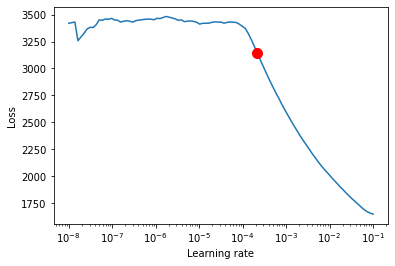

In [68]:
trainer = pl.Trainer(gpus=1,
                     accumulate_grad_batches=hparams["accum_grads"],)

model_wav = Wav2VecNet(hparams=hparams)

# Run learning rate finder
lr_finder = trainer.tuner.lr_find(model_wav, train_dataloader, val_dataloader, max_lr=1e-1)
# lr_finder = trainer.tuner.lr_find(model_wav, train_dataloader, val_dataloader)

# Results can be found in
lr_finder.results

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()
print(new_lr)

# update hparams of the model
hparams["lr"] = new_lr

del trainer, model_wav
torch.cuda.empty_cache()

In [69]:
hparams["lr"]

0.00021877616239495524

# Defining the Wav2VecNet and training

In [70]:
pl_model= Wav2VecNet(hparams=hparams)

checkpoint_path = 'Wav2Vec2_Fairseq/epoch=0.ckpt'
checkpoint_dir = os.path.dirname(os.path.abspath(checkpoint_path))
print(f'Files in {checkpoint_dir}: {os.listdir(checkpoint_dir)}')
print(f'Saving checkpoints to {checkpoint_dir}')
checkpoint_callback = pl.callbacks.ModelCheckpoint(prefix=hparams["version"],
                                                    dirpath=checkpoint_dir,
                                                    save_top_k=1,
                                                    verbose = True, 
                                                    monitor="val_wer", mode="min")
early_stop_callback = pl.callbacks.EarlyStopping(monitor='val_wer', patience=hparams["patience"], mode='min')
lr_monitor = pl.callbacks.LearningRateMonitor(logging_interval='step')


trainer = pl.Trainer(gpus=1, 
                     # precision=16,
                     logger=neptune_logger,
                     num_sanity_val_steps=0,
                     accumulate_grad_batches=hparams["accum_grads"],
                     checkpoint_callback=checkpoint_callback, 
                     callbacks=[early_stop_callback, lr_monitor],
                     max_epochs=hparams["max_epochs"])

/opt/conda/envs/wav2vec/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: Checkpoint directory /home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores


Files in /home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq: ['.ipynb_checkpoints']
Saving checkpoints to /home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq


In [71]:
trainer.fit(pl_model, train_dataloader, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
psutil is not installed. You will not be able to abort this experiment from the UI.
psutil is not installed. Hardware metrics will not be collected.


https://app.neptune.ai/orllem/Wav2vec2/e/WAV-112



  | Name      | Type                   | Params
-----------------------------------------------------
0 | model     | Wav2VecCtc             | 315 M 
1 | criterion | CtcCriterionFinetuning | 0     
-----------------------------------------------------
311 M     Trainable params
4.2 M     Non-trainable params
315 M     Total params
1,261.943 Total estimated model params size (MB)


Epoch 0, global step 499: val_wer reached 40.66338 (best 40.66338), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=0-step=499.ckpt" as top 1


Epoch 1, global step 999: val_wer reached 33.62256 (best 33.62256), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=1-step=999.ckpt" as top 1


Epoch 2, global step 1499: val_wer reached 28.12355 (best 28.12355), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=2-step=1499.ckpt" as top 1


Epoch 3, global step 1999: val_wer reached 25.53114 (best 25.53114), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=3-step=1999.ckpt" as top 1


Epoch 4, global step 2499: val_wer reached 23.77779 (best 23.77779), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=4-step=2499.ckpt" as top 1


Epoch 5, global step 2999: val_wer reached 22.52851 (best 22.52851), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=5-step=2999.ckpt" as top 1


Epoch 6, global step 3499: val_wer reached 21.59658 (best 21.59658), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=6-step=3499.ckpt" as top 1


Epoch 7, global step 3999: val_wer reached 20.93051 (best 20.93051), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=7-step=3999.ckpt" as top 1


Epoch 8, global step 4499: val_wer reached 20.39519 (best 20.39519), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=8-step=4499.ckpt" as top 1


Epoch 9, global step 4999: val_wer reached 19.98622 (best 19.98622), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=9-step=4999.ckpt" as top 1


Epoch 10, global step 5499: val_wer reached 19.59596 (best 19.59596), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=10-step=5499.ckpt" as top 1


Epoch 11, global step 5999: val_wer reached 19.38220 (best 19.38220), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=11-step=5999.ckpt" as top 1


Epoch 12, global step 6499: val_wer reached 19.17983 (best 19.17983), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=12-step=6499.ckpt" as top 1


Epoch 13, global step 6999: val_wer reached 19.02175 (best 19.02175), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=13-step=6999.ckpt" as top 1


Epoch 14, global step 7499: val_wer reached 18.83618 (best 18.83618), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=14-step=7499.ckpt" as top 1


Epoch 15, global step 7999: val_wer reached 18.66863 (best 18.66863), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=15-step=7999.ckpt" as top 1


Epoch 16, global step 8499: val_wer reached 18.55905 (best 18.55905), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=16-step=8499.ckpt" as top 1


Epoch 17, global step 8999: val_wer reached 18.46534 (best 18.46534), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=17-step=8999.ckpt" as top 1


Epoch 18, global step 9499: val_wer reached 18.35765 (best 18.35765), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=18-step=9499.ckpt" as top 1


Epoch 19, global step 9999: val_wer reached 18.30341 (best 18.30341), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=19-step=9999.ckpt" as top 1


Epoch 20, global step 10499: val_wer reached 18.23505 (best 18.23505), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=20-step=10499.ckpt" as top 1


Epoch 21, global step 10999: val_wer reached 18.17600 (best 18.17600), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=21-step=10999.ckpt" as top 1


Epoch 22, global step 11499: val_wer reached 18.13728 (best 18.13728), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=22-step=11499.ckpt" as top 1


Epoch 23, global step 11999: val_wer reached 18.08721 (best 18.08721), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=23-step=11999.ckpt" as top 1


Epoch 24, global step 12499: val_wer reached 18.02962 (best 18.02962), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=24-step=12499.ckpt" as top 1


Epoch 25, global step 12999: val_wer reached 17.99999 (best 17.99999), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=25-step=12999.ckpt" as top 1


Epoch 26, global step 13499: val_wer reached 17.94420 (best 17.94420), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=26-step=13499.ckpt" as top 1


Epoch 27, global step 13999: val_wer reached 17.90250 (best 17.90250), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=27-step=13999.ckpt" as top 1


Epoch 28, global step 14499: val_wer reached 17.86419 (best 17.86419), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=28-step=14499.ckpt" as top 1


Epoch 29, global step 14999: val_wer reached 17.84437 (best 17.84437), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=29-step=14999.ckpt" as top 1


Epoch 30, global step 15499: val_wer reached 17.82880 (best 17.82880), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=30-step=15499.ckpt" as top 1


Epoch 31, global step 15999: val_wer reached 17.81044 (best 17.81044), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=31-step=15999.ckpt" as top 1


Epoch 32, global step 16499: val_wer reached 17.79176 (best 17.79176), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=32-step=16499.ckpt" as top 1


Epoch 33, step 16999: val_wer was not in top 1


Epoch 34, global step 17499: val_wer reached 17.78233 (best 17.78233), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=34-step=17499.ckpt" as top 1


Epoch 35, global step 17999: val_wer reached 17.76789 (best 17.76789), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=35-step=17999.ckpt" as top 1


Epoch 36, global step 18499: val_wer reached 17.76026 (best 17.76026), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=36-step=18499.ckpt" as top 1


Epoch 37, global step 18999: val_wer reached 17.74625 (best 17.74625), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=37-step=18999.ckpt" as top 1


Epoch 38, global step 19499: val_wer reached 17.73560 (best 17.73560), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=38-step=19499.ckpt" as top 1


Epoch 39, global step 19999: val_wer reached 17.72832 (best 17.72832), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=39-step=19999.ckpt" as top 1


Epoch 40, global step 20499: val_wer reached 17.72375 (best 17.72375), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=40-step=20499.ckpt" as top 1


Epoch 41, global step 20999: val_wer reached 17.72173 (best 17.72173), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=41-step=20999.ckpt" as top 1


Epoch 42, global step 21499: val_wer reached 17.71804 (best 17.71804), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=42-step=21499.ckpt" as top 1


Epoch 43, global step 21999: val_wer reached 17.69963 (best 17.69963), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=43-step=21999.ckpt" as top 1


Epoch 44, global step 22499: val_wer reached 17.68996 (best 17.68996), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=44-step=22499.ckpt" as top 1


Epoch 45, global step 22999: val_wer reached 17.66832 (best 17.66832), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=45-step=22999.ckpt" as top 1


Epoch 46, global step 23499: val_wer reached 17.65118 (best 17.65118), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=46-step=23499.ckpt" as top 1


Epoch 47, global step 23999: val_wer reached 17.64633 (best 17.64633), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=47-step=23999.ckpt" as top 1


Epoch 48, step 24499: val_wer was not in top 1


Epoch 49, global step 24999: val_wer reached 17.64485 (best 17.64485), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=49-step=24999.ckpt" as top 1


Epoch 50, step 25499: val_wer was not in top 1


Epoch 51, global step 25999: val_wer reached 17.64378 (best 17.64378), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=51-step=25999.ckpt" as top 1


Epoch 52, global step 26499: val_wer reached 17.63489 (best 17.63489), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=52-step=26499.ckpt" as top 1


Epoch 53, global step 26999: val_wer reached 17.63035 (best 17.63035), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=53-step=26999.ckpt" as top 1


Epoch 54, global step 27499: val_wer reached 17.61450 (best 17.61450), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=54-step=27499.ckpt" as top 1


Epoch 55, global step 27999: val_wer reached 17.61050 (best 17.61050), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=55-step=27999.ckpt" as top 1


Epoch 56, global step 28499: val_wer reached 17.60598 (best 17.60598), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=56-step=28499.ckpt" as top 1


Epoch 57, global step 28999: val_wer reached 17.59822 (best 17.59822), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=57-step=28999.ckpt" as top 1


Epoch 58, step 29499: val_wer was not in top 1


Epoch 59, global step 29999: val_wer reached 17.58763 (best 17.58763), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=59-step=29999.ckpt" as top 1


Epoch 60, global step 30499: val_wer reached 17.58350 (best 17.58350), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=60-step=30499.ckpt" as top 1


Epoch 61, step 30999: val_wer was not in top 1


Epoch 62, global step 31499: val_wer reached 17.57339 (best 17.57339), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=62-step=31499.ckpt" as top 1


Epoch 63, global step 31999: val_wer reached 17.56961 (best 17.56961), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=63-step=31999.ckpt" as top 1


Epoch 64, global step 32499: val_wer reached 17.56920 (best 17.56920), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=64-step=32499.ckpt" as top 1


Epoch 65, global step 32999: val_wer reached 17.56534 (best 17.56534), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=65-step=32999.ckpt" as top 1


Epoch 66, global step 33499: val_wer reached 17.56299 (best 17.56299), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=66-step=33499.ckpt" as top 1


Epoch 67, global step 33999: val_wer reached 17.56006 (best 17.56006), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=67-step=33999.ckpt" as top 1


Epoch 68, global step 34499: val_wer reached 17.55490 (best 17.55490), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=68-step=34499.ckpt" as top 1


Epoch 69, global step 34999: val_wer reached 17.54953 (best 17.54953), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=69-step=34999.ckpt" as top 1


Epoch 70, global step 35499: val_wer reached 17.54810 (best 17.54810), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=70-step=35499.ckpt" as top 1


Epoch 71, global step 35999: val_wer reached 17.54771 (best 17.54771), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=71-step=35999.ckpt" as top 1


Epoch 72, global step 36499: val_wer reached 17.54690 (best 17.54690), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=72-step=36499.ckpt" as top 1


Epoch 73, step 36999: val_wer was not in top 1


Epoch 74, step 37499: val_wer was not in top 1


Epoch 75, step 37999: val_wer was not in top 1


Epoch 76, global step 38499: val_wer reached 17.54017 (best 17.54017), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=76-step=38499.ckpt" as top 1


Epoch 77, global step 38999: val_wer reached 17.53158 (best 17.53158), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=77-step=38999.ckpt" as top 1


Epoch 78, step 39499: val_wer was not in top 1


Epoch 79, global step 39999: val_wer reached 17.52925 (best 17.52925), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=79-step=39999.ckpt" as top 1


Epoch 80, global step 40499: val_wer reached 17.51858 (best 17.51858), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=80-step=40499.ckpt" as top 1


Epoch 81, global step 40999: val_wer reached 17.51244 (best 17.51244), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=81-step=40999.ckpt" as top 1


Epoch 82, global step 41499: val_wer reached 17.51152 (best 17.51152), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=82-step=41499.ckpt" as top 1


Epoch 83, global step 41999: val_wer reached 17.51052 (best 17.51052), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=83-step=41999.ckpt" as top 1


Epoch 84, global step 42499: val_wer reached 17.50845 (best 17.50845), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=84-step=42499.ckpt" as top 1


Epoch 85, global step 42999: val_wer reached 17.50365 (best 17.50365), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=85-step=42999.ckpt" as top 1


Epoch 86, global step 43499: val_wer reached 17.49865 (best 17.49865), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=86-step=43499.ckpt" as top 1


Epoch 87, global step 43999: val_wer reached 17.49432 (best 17.49432), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=87-step=43999.ckpt" as top 1


Epoch 88, global step 44499: val_wer reached 17.49265 (best 17.49265), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=88-step=44499.ckpt" as top 1


Epoch 89, global step 44999: val_wer reached 17.49216 (best 17.49216), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=89-step=44999.ckpt" as top 1


Epoch 90, global step 45499: val_wer reached 17.48917 (best 17.48917), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=90-step=45499.ckpt" as top 1


Epoch 91, global step 45999: val_wer reached 17.48104 (best 17.48104), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=91-step=45999.ckpt" as top 1


Epoch 92, global step 46499: val_wer reached 17.47271 (best 17.47271), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=92-step=46499.ckpt" as top 1


Epoch 93, global step 46999: val_wer reached 17.46560 (best 17.46560), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=93-step=46999.ckpt" as top 1


Epoch 94, global step 47499: val_wer reached 17.46351 (best 17.46351), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=94-step=47499.ckpt" as top 1


Epoch 95, global step 47999: val_wer reached 17.45831 (best 17.45831), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=95-step=47999.ckpt" as top 1


Epoch 96, global step 48499: val_wer reached 17.45203 (best 17.45203), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=96-step=48499.ckpt" as top 1


Epoch 97, global step 48999: val_wer reached 17.44200 (best 17.44200), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=97-step=48999.ckpt" as top 1


Epoch 98, global step 49499: val_wer reached 17.43271 (best 17.43271), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=98-step=49499.ckpt" as top 1


Epoch 99, global step 49999: val_wer reached 17.42959 (best 17.42959), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=99-step=49999.ckpt" as top 1


Epoch 100, global step 50499: val_wer reached 17.42812 (best 17.42812), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=100-step=50499.ckpt" as top 1


Epoch 101, global step 50999: val_wer reached 17.42711 (best 17.42711), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=101-step=50999.ckpt" as top 1


Epoch 102, global step 51499: val_wer reached 17.42630 (best 17.42630), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=102-step=51499.ckpt" as top 1


Epoch 103, step 51999: val_wer was not in top 1


Epoch 104, global step 52499: val_wer reached 17.42492 (best 17.42492), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=104-step=52499.ckpt" as top 1


Epoch 105, global step 52999: val_wer reached 17.42060 (best 17.42060), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=105-step=52999.ckpt" as top 1


Epoch 106, step 53499: val_wer was not in top 1


Epoch 107, step 53999: val_wer was not in top 1


Epoch 108, step 54499: val_wer was not in top 1


Epoch 109, global step 54999: val_wer reached 17.41740 (best 17.41740), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=109-step=54999.ckpt" as top 1


Epoch 110, global step 55499: val_wer reached 17.41235 (best 17.41235), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=110-step=55499.ckpt" as top 1


Epoch 111, global step 55999: val_wer reached 17.41091 (best 17.41091), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=111-step=55999.ckpt" as top 1


Epoch 112, global step 56499: val_wer reached 17.40672 (best 17.40672), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=112-step=56499.ckpt" as top 1


Epoch 113, global step 56999: val_wer reached 17.40236 (best 17.40236), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=113-step=56999.ckpt" as top 1


Epoch 114, global step 57499: val_wer reached 17.39730 (best 17.39730), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=114-step=57499.ckpt" as top 1


Epoch 115, global step 57999: val_wer reached 17.39430 (best 17.39430), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=115-step=57999.ckpt" as top 1


Epoch 116, global step 58499: val_wer reached 17.39163 (best 17.39163), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=116-step=58499.ckpt" as top 1


Epoch 117, global step 58999: val_wer reached 17.38810 (best 17.38810), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=117-step=58999.ckpt" as top 1


Epoch 118, global step 59499: val_wer reached 17.38452 (best 17.38452), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=118-step=59499.ckpt" as top 1


Epoch 119, global step 59999: val_wer reached 17.37841 (best 17.37841), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=119-step=59999.ckpt" as top 1


Epoch 120, global step 60499: val_wer reached 17.37426 (best 17.37426), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=120-step=60499.ckpt" as top 1


Epoch 121, global step 60999: val_wer reached 17.36921 (best 17.36921), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=121-step=60999.ckpt" as top 1


Epoch 122, global step 61499: val_wer reached 17.36069 (best 17.36069), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=122-step=61499.ckpt" as top 1


Epoch 123, global step 61999: val_wer reached 17.35545 (best 17.35545), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=123-step=61999.ckpt" as top 1


Epoch 124, global step 62499: val_wer reached 17.34836 (best 17.34836), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=124-step=62499.ckpt" as top 1


Epoch 125, global step 62999: val_wer reached 17.33968 (best 17.33968), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=125-step=62999.ckpt" as top 1


Epoch 126, global step 63499: val_wer reached 17.33385 (best 17.33385), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=126-step=63499.ckpt" as top 1


Epoch 127, global step 63999: val_wer reached 17.33216 (best 17.33216), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=127-step=63999.ckpt" as top 1


Epoch 128, global step 64499: val_wer reached 17.32965 (best 17.32965), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=128-step=64499.ckpt" as top 1


Epoch 129, global step 64999: val_wer reached 17.32250 (best 17.32250), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=129-step=64999.ckpt" as top 1


Epoch 130, global step 65499: val_wer reached 17.31755 (best 17.31755), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=130-step=65499.ckpt" as top 1


Epoch 131, global step 65999: val_wer reached 17.31172 (best 17.31172), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=131-step=65999.ckpt" as top 1


Epoch 132, global step 66499: val_wer reached 17.30646 (best 17.30646), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=132-step=66499.ckpt" as top 1


Epoch 133, global step 66999: val_wer reached 17.30030 (best 17.30030), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=133-step=66999.ckpt" as top 1


Epoch 134, global step 67499: val_wer reached 17.29605 (best 17.29605), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=134-step=67499.ckpt" as top 1


Epoch 135, global step 67999: val_wer reached 17.29082 (best 17.29082), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=135-step=67999.ckpt" as top 1


Epoch 136, global step 68499: val_wer reached 17.28356 (best 17.28356), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=136-step=68499.ckpt" as top 1


Epoch 137, global step 68999: val_wer reached 17.27530 (best 17.27530), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=137-step=68999.ckpt" as top 1


Epoch 138, global step 69499: val_wer reached 17.26837 (best 17.26837), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=138-step=69499.ckpt" as top 1


Epoch 139, global step 69999: val_wer reached 17.26100 (best 17.26100), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=139-step=69999.ckpt" as top 1


Epoch 140, global step 70499: val_wer reached 17.25562 (best 17.25562), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=140-step=70499.ckpt" as top 1


Epoch 141, global step 70999: val_wer reached 17.25245 (best 17.25245), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=141-step=70999.ckpt" as top 1


Epoch 142, global step 71499: val_wer reached 17.24981 (best 17.24981), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=142-step=71499.ckpt" as top 1


Epoch 143, global step 71999: val_wer reached 17.24769 (best 17.24769), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=143-step=71999.ckpt" as top 1


Epoch 144, global step 72499: val_wer reached 17.24364 (best 17.24364), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=144-step=72499.ckpt" as top 1


Epoch 145, global step 72999: val_wer reached 17.24068 (best 17.24068), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=145-step=72999.ckpt" as top 1


Epoch 146, global step 73499: val_wer reached 17.23550 (best 17.23550), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=146-step=73499.ckpt" as top 1


Epoch 147, global step 73999: val_wer reached 17.22925 (best 17.22925), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=147-step=73999.ckpt" as top 1


Epoch 148, global step 74499: val_wer reached 17.22249 (best 17.22249), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=148-step=74499.ckpt" as top 1


Epoch 149, global step 74999: val_wer reached 17.21702 (best 17.21702), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=149-step=74999.ckpt" as top 1


Epoch 150, global step 75499: val_wer reached 17.20896 (best 17.20896), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=150-step=75499.ckpt" as top 1


Epoch 151, global step 75999: val_wer reached 17.20220 (best 17.20220), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=151-step=75999.ckpt" as top 1


Epoch 152, global step 76499: val_wer reached 17.19547 (best 17.19547), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=152-step=76499.ckpt" as top 1


Epoch 153, global step 76999: val_wer reached 17.18950 (best 17.18950), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=153-step=76999.ckpt" as top 1


Epoch 154, global step 77499: val_wer reached 17.18385 (best 17.18385), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=154-step=77499.ckpt" as top 1


Epoch 155, global step 77999: val_wer reached 17.17800 (best 17.17800), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=155-step=77999.ckpt" as top 1


Epoch 156, global step 78499: val_wer reached 17.17362 (best 17.17362), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=156-step=78499.ckpt" as top 1


Epoch 157, global step 78999: val_wer reached 17.16767 (best 17.16767), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=157-step=78999.ckpt" as top 1


Epoch 158, global step 79499: val_wer reached 17.16035 (best 17.16035), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=158-step=79499.ckpt" as top 1


Epoch 159, global step 79999: val_wer reached 17.15447 (best 17.15447), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=159-step=79999.ckpt" as top 1


Epoch 160, global step 80499: val_wer reached 17.14761 (best 17.14761), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=160-step=80499.ckpt" as top 1


Epoch 161, global step 80999: val_wer reached 17.13996 (best 17.13996), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=161-step=80999.ckpt" as top 1


Epoch 162, global step 81499: val_wer reached 17.12899 (best 17.12899), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=162-step=81499.ckpt" as top 1


Epoch 163, global step 81999: val_wer reached 17.11977 (best 17.11977), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=163-step=81999.ckpt" as top 1


Epoch 164, global step 82499: val_wer reached 17.11217 (best 17.11217), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=164-step=82499.ckpt" as top 1


Epoch 165, global step 82999: val_wer reached 17.10224 (best 17.10224), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=165-step=82999.ckpt" as top 1


Epoch 166, global step 83499: val_wer reached 17.09154 (best 17.09154), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=166-step=83499.ckpt" as top 1


Epoch 167, global step 83999: val_wer reached 17.08352 (best 17.08352), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=167-step=83999.ckpt" as top 1


Epoch 168, global step 84499: val_wer reached 17.07463 (best 17.07463), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=168-step=84499.ckpt" as top 1


Epoch 169, global step 84999: val_wer reached 17.06491 (best 17.06491), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=169-step=84999.ckpt" as top 1


Epoch 170, global step 85499: val_wer reached 17.05505 (best 17.05505), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=170-step=85499.ckpt" as top 1


Epoch 171, global step 85999: val_wer reached 17.04582 (best 17.04582), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=171-step=85999.ckpt" as top 1


Epoch 172, global step 86499: val_wer reached 17.03758 (best 17.03758), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=172-step=86499.ckpt" as top 1


Epoch 173, global step 86999: val_wer reached 17.02669 (best 17.02669), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=173-step=86999.ckpt" as top 1


Epoch 174, global step 87499: val_wer reached 17.01429 (best 17.01429), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=174-step=87499.ckpt" as top 1


Epoch 175, global step 87999: val_wer reached 17.00250 (best 17.00250), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=175-step=87999.ckpt" as top 1


Epoch 176, global step 88499: val_wer reached 16.99049 (best 16.99049), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=176-step=88499.ckpt" as top 1


Epoch 177, global step 88999: val_wer reached 16.97990 (best 16.97990), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=177-step=88999.ckpt" as top 1


Epoch 178, global step 89499: val_wer reached 16.96926 (best 16.96926), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=178-step=89499.ckpt" as top 1


Epoch 179, global step 89999: val_wer reached 16.95867 (best 16.95867), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=179-step=89999.ckpt" as top 1


Epoch 180, global step 90499: val_wer reached 16.94846 (best 16.94846), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=180-step=90499.ckpt" as top 1


Epoch 181, global step 90999: val_wer reached 16.93881 (best 16.93881), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=181-step=90999.ckpt" as top 1


Epoch 182, global step 91499: val_wer reached 16.93020 (best 16.93020), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=182-step=91499.ckpt" as top 1


Epoch 183, global step 91999: val_wer reached 16.92217 (best 16.92217), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=183-step=91999.ckpt" as top 1


Epoch 184, global step 92499: val_wer reached 16.91340 (best 16.91340), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=184-step=92499.ckpt" as top 1


Epoch 185, global step 92999: val_wer reached 16.90381 (best 16.90381), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=185-step=92999.ckpt" as top 1


Epoch 186, global step 93499: val_wer reached 16.89444 (best 16.89444), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=186-step=93499.ckpt" as top 1


Epoch 187, global step 93999: val_wer reached 16.88457 (best 16.88457), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=187-step=93999.ckpt" as top 1


Epoch 188, global step 94499: val_wer reached 16.87446 (best 16.87446), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=188-step=94499.ckpt" as top 1


Epoch 189, global step 94999: val_wer reached 16.86504 (best 16.86504), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=189-step=94999.ckpt" as top 1


Epoch 190, global step 95499: val_wer reached 16.85662 (best 16.85662), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=190-step=95499.ckpt" as top 1


Epoch 191, global step 95999: val_wer reached 16.84639 (best 16.84639), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=191-step=95999.ckpt" as top 1


Epoch 192, global step 96499: val_wer reached 16.83470 (best 16.83470), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=192-step=96499.ckpt" as top 1


Epoch 193, global step 96999: val_wer reached 16.82328 (best 16.82328), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=193-step=96999.ckpt" as top 1


Epoch 194, global step 97499: val_wer reached 16.81224 (best 16.81224), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=194-step=97499.ckpt" as top 1


Epoch 195, global step 97999: val_wer reached 16.80111 (best 16.80111), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=195-step=97999.ckpt" as top 1
Unexpected error in ping thread.
Traceback (most recent call last):
  File "/opt/conda/envs/wav2vec/lib/python3.7/site-packages/neptune/internal/threads/ping_thread.py", line 37, in run
    self.__backend.ping_experiment(self.__experiment)
  File "/opt/conda/envs/wav2vec/lib/python3.7/site-packages/neptune/internal/api_clients/hosted_api_clients/hosted_alpha_leaderboard_api_client.py", line 392, in ping_experiment
    self.leaderboard_swagger_client.api.ping(experimentId=str(experiment.internal_id)).response().result
  File "/opt/conda/envs/wav2vec/lib/python3.7/site-packages/bravado/http_future.py", line 239, in response
    six.reraise(*sys.exc_info())
  File "/opt/conda/envs/wav2vec/lib/python3.7/site-packages/six.py", line 719, in reraise
    raise value
  File 

Unexpected error in ping thread.
Traceback (most recent call last):
  File "/opt/conda/envs/wav2vec/lib/python3.7/site-packages/neptune/internal/threads/ping_thread.py", line 37, in run
    self.__backend.ping_experiment(self.__experiment)
  File "/opt/conda/envs/wav2vec/lib/python3.7/site-packages/neptune/internal/api_clients/hosted_api_clients/hosted_alpha_leaderboard_api_client.py", line 392, in ping_experiment
    self.leaderboard_swagger_client.api.ping(experimentId=str(experiment.internal_id)).response().result
  File "/opt/conda/envs/wav2vec/lib/python3.7/site-packages/bravado/http_future.py", line 239, in response
    six.reraise(*sys.exc_info())
  File "/opt/conda/envs/wav2vec/lib/python3.7/site-packages/six.py", line 719, in reraise
    raise value
  File "/opt/conda/envs/wav2vec/lib/python3.7/site-packages/bravado/http_future.py", line 200, in response
    swagger_result = self._get_swagger_result(incoming_response)
  File "/opt/conda/envs/wav2vec/lib/python3.7/site-packages

Epoch 197, global step 98999: val_wer reached 16.78199 (best 16.78199), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=197-step=98999.ckpt" as top 1


Epoch 198, global step 99499: val_wer reached 16.77263 (best 16.77263), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=198-step=99499.ckpt" as top 1


Epoch 199, global step 99999: val_wer reached 16.76419 (best 16.76419), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=199-step=99999.ckpt" as top 1


Epoch 200, global step 100499: val_wer reached 16.75492 (best 16.75492), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=200-step=100499.ckpt" as top 1


Epoch 201, global step 100999: val_wer reached 16.74466 (best 16.74466), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=201-step=100999.ckpt" as top 1


Epoch 202, global step 101499: val_wer reached 16.73314 (best 16.73314), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=202-step=101499.ckpt" as top 1


Epoch 203, global step 101999: val_wer reached 16.72287 (best 16.72287), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=203-step=101999.ckpt" as top 1


Epoch 204, global step 102499: val_wer reached 16.71383 (best 16.71383), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=204-step=102499.ckpt" as top 1


Epoch 205, global step 102999: val_wer reached 16.70352 (best 16.70352), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=205-step=102999.ckpt" as top 1


Epoch 206, global step 103499: val_wer reached 16.69390 (best 16.69390), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=206-step=103499.ckpt" as top 1


Epoch 207, global step 103999: val_wer reached 16.68398 (best 16.68398), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=207-step=103999.ckpt" as top 1


Epoch 208, global step 104499: val_wer reached 16.67336 (best 16.67336), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=208-step=104499.ckpt" as top 1


Epoch 209, global step 104999: val_wer reached 16.66137 (best 16.66137), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=209-step=104999.ckpt" as top 1


Unexpected error in ping thread.
Traceback (most recent call last):
  File "/opt/conda/envs/wav2vec/lib/python3.7/site-packages/neptune/internal/threads/ping_thread.py", line 37, in run
    self.__backend.ping_experiment(self.__experiment)
  File "/opt/conda/envs/wav2vec/lib/python3.7/site-packages/neptune/internal/api_clients/hosted_api_clients/hosted_alpha_leaderboard_api_client.py", line 392, in ping_experiment
    self.leaderboard_swagger_client.api.ping(experimentId=str(experiment.internal_id)).response().result
  File "/opt/conda/envs/wav2vec/lib/python3.7/site-packages/bravado/http_future.py", line 239, in response
    six.reraise(*sys.exc_info())
  File "/opt/conda/envs/wav2vec/lib/python3.7/site-packages/six.py", line 719, in reraise
    raise value
  File "/opt/conda/envs/wav2vec/lib/python3.7/site-packages/bravado/http_future.py", line 200, in response
    swagger_result = self._get_swagger_result(incoming_response)
  File "/opt/conda/envs/wav2vec/lib/python3.7/site-packages

Epoch 211, global step 105999: val_wer reached 16.63550 (best 16.63550), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=211-step=105999.ckpt" as top 1


Epoch 212, global step 106499: val_wer reached 16.62287 (best 16.62287), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=212-step=106499.ckpt" as top 1


Epoch 213, global step 106999: val_wer reached 16.61154 (best 16.61154), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=213-step=106999.ckpt" as top 1


Epoch 214, global step 107499: val_wer reached 16.60051 (best 16.60051), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=214-step=107499.ckpt" as top 1


Epoch 215, global step 107999: val_wer reached 16.58959 (best 16.58959), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=215-step=107999.ckpt" as top 1


Epoch 216, global step 108499: val_wer reached 16.57820 (best 16.57820), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=216-step=108499.ckpt" as top 1


Epoch 217, global step 108999: val_wer reached 16.56739 (best 16.56739), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=217-step=108999.ckpt" as top 1


Epoch 218, global step 109499: val_wer reached 16.55603 (best 16.55603), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=218-step=109499.ckpt" as top 1


Epoch 219, global step 109999: val_wer reached 16.54408 (best 16.54408), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=219-step=109999.ckpt" as top 1


Epoch 220, global step 110499: val_wer reached 16.53183 (best 16.53183), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=220-step=110499.ckpt" as top 1


Epoch 221, global step 110999: val_wer reached 16.51936 (best 16.51936), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=221-step=110999.ckpt" as top 1


Epoch 222, global step 111499: val_wer reached 16.50606 (best 16.50606), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=222-step=111499.ckpt" as top 1


Epoch 223, global step 111999: val_wer reached 16.49274 (best 16.49274), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=223-step=111999.ckpt" as top 1


Epoch 224, global step 112499: val_wer reached 16.48014 (best 16.48014), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=224-step=112499.ckpt" as top 1


Epoch 225, global step 112999: val_wer reached 16.46702 (best 16.46702), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=225-step=112999.ckpt" as top 1


Epoch 226, global step 113499: val_wer reached 16.45467 (best 16.45467), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=226-step=113499.ckpt" as top 1


Epoch 227, global step 113999: val_wer reached 16.44251 (best 16.44251), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=227-step=113999.ckpt" as top 1


Epoch 228, global step 114499: val_wer reached 16.43061 (best 16.43061), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=228-step=114499.ckpt" as top 1


Epoch 229, global step 114999: val_wer reached 16.41883 (best 16.41883), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=229-step=114999.ckpt" as top 1


Epoch 230, global step 115499: val_wer reached 16.40765 (best 16.40765), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=230-step=115499.ckpt" as top 1


Epoch 231, global step 115999: val_wer reached 16.39553 (best 16.39553), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=231-step=115999.ckpt" as top 1


Epoch 232, global step 116499: val_wer reached 16.38352 (best 16.38352), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=232-step=116499.ckpt" as top 1


Epoch 233, global step 116999: val_wer reached 16.37212 (best 16.37212), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=233-step=116999.ckpt" as top 1


Epoch 234, global step 117499: val_wer reached 16.35967 (best 16.35967), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=234-step=117499.ckpt" as top 1


Epoch 235, global step 117999: val_wer reached 16.34623 (best 16.34623), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=235-step=117999.ckpt" as top 1


Epoch 236, global step 118499: val_wer reached 16.33332 (best 16.33332), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=236-step=118499.ckpt" as top 1


Epoch 237, global step 118999: val_wer reached 16.31984 (best 16.31984), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=237-step=118999.ckpt" as top 1


Epoch 238, global step 119499: val_wer reached 16.30643 (best 16.30643), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=238-step=119499.ckpt" as top 1


Epoch 239, global step 119999: val_wer reached 16.29350 (best 16.29350), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=239-step=119999.ckpt" as top 1


Epoch 240, global step 120499: val_wer reached 16.28058 (best 16.28058), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=240-step=120499.ckpt" as top 1


Epoch 241, global step 120999: val_wer reached 16.26727 (best 16.26727), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=241-step=120999.ckpt" as top 1


Epoch 242, global step 121499: val_wer reached 16.25500 (best 16.25500), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=242-step=121499.ckpt" as top 1


Epoch 243, global step 121999: val_wer reached 16.24311 (best 16.24311), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=243-step=121999.ckpt" as top 1


Epoch 244, global step 122499: val_wer reached 16.23068 (best 16.23068), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=244-step=122499.ckpt" as top 1


Epoch 245, global step 122999: val_wer reached 16.21788 (best 16.21788), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=245-step=122999.ckpt" as top 1


Epoch 246, global step 123499: val_wer reached 16.20523 (best 16.20523), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=246-step=123499.ckpt" as top 1


Epoch 247, global step 123999: val_wer reached 16.19275 (best 16.19275), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=247-step=123999.ckpt" as top 1


Epoch 248, global step 124499: val_wer reached 16.17998 (best 16.17998), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=248-step=124499.ckpt" as top 1


Epoch 249, global step 124999: val_wer reached 16.16700 (best 16.16700), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=249-step=124999.ckpt" as top 1


Epoch 250, global step 125499: val_wer reached 16.15421 (best 16.15421), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=250-step=125499.ckpt" as top 1


Epoch 251, global step 125999: val_wer reached 16.14088 (best 16.14088), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=251-step=125999.ckpt" as top 1


Epoch 252, global step 126499: val_wer reached 16.12876 (best 16.12876), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=252-step=126499.ckpt" as top 1


Epoch 253, global step 126999: val_wer reached 16.11640 (best 16.11640), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=253-step=126999.ckpt" as top 1


Epoch 254, global step 127499: val_wer reached 16.10331 (best 16.10331), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=254-step=127499.ckpt" as top 1


Epoch 255, global step 127999: val_wer reached 16.09077 (best 16.09077), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=255-step=127999.ckpt" as top 1


Epoch 256, global step 128499: val_wer reached 16.07859 (best 16.07859), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=256-step=128499.ckpt" as top 1


Epoch 257, global step 128999: val_wer reached 16.06675 (best 16.06675), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=257-step=128999.ckpt" as top 1


Epoch 258, global step 129499: val_wer reached 16.05478 (best 16.05478), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=258-step=129499.ckpt" as top 1


Epoch 259, global step 129999: val_wer reached 16.04291 (best 16.04291), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=259-step=129999.ckpt" as top 1


Epoch 260, global step 130499: val_wer reached 16.03137 (best 16.03137), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=260-step=130499.ckpt" as top 1


Epoch 261, global step 130999: val_wer reached 16.01990 (best 16.01990), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=261-step=130999.ckpt" as top 1


Epoch 262, global step 131499: val_wer reached 16.00809 (best 16.00809), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=262-step=131499.ckpt" as top 1


Epoch 263, global step 131999: val_wer reached 15.99626 (best 15.99626), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=263-step=131999.ckpt" as top 1


Epoch 264, global step 132499: val_wer reached 15.98448 (best 15.98448), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=264-step=132499.ckpt" as top 1


Epoch 265, global step 132999: val_wer reached 15.97288 (best 15.97288), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=265-step=132999.ckpt" as top 1


Epoch 266, global step 133499: val_wer reached 15.96169 (best 15.96169), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=266-step=133499.ckpt" as top 1


Epoch 267, global step 133999: val_wer reached 15.95048 (best 15.95048), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=267-step=133999.ckpt" as top 1


Epoch 268, global step 134499: val_wer reached 15.93934 (best 15.93934), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=268-step=134499.ckpt" as top 1


Epoch 269, global step 134999: val_wer reached 15.92807 (best 15.92807), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=269-step=134999.ckpt" as top 1


Epoch 270, global step 135499: val_wer reached 15.91674 (best 15.91674), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=270-step=135499.ckpt" as top 1


Epoch 271, global step 135999: val_wer reached 15.90542 (best 15.90542), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=271-step=135999.ckpt" as top 1


Epoch 272, global step 136499: val_wer reached 15.89405 (best 15.89405), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=272-step=136499.ckpt" as top 1


Epoch 273, global step 136999: val_wer reached 15.88271 (best 15.88271), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=273-step=136999.ckpt" as top 1


Epoch 274, global step 137499: val_wer reached 15.87147 (best 15.87147), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=274-step=137499.ckpt" as top 1


Epoch 275, global step 137999: val_wer reached 15.86018 (best 15.86018), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=275-step=137999.ckpt" as top 1


Epoch 276, global step 138499: val_wer reached 15.84877 (best 15.84877), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=276-step=138499.ckpt" as top 1


Epoch 277, global step 138999: val_wer reached 15.83736 (best 15.83736), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=277-step=138999.ckpt" as top 1


Epoch 278, global step 139499: val_wer reached 15.82636 (best 15.82636), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=278-step=139499.ckpt" as top 1


Epoch 279, global step 139999: val_wer reached 15.81522 (best 15.81522), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=279-step=139999.ckpt" as top 1


Epoch 280, global step 140499: val_wer reached 15.80425 (best 15.80425), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=280-step=140499.ckpt" as top 1


Epoch 281, global step 140999: val_wer reached 15.79331 (best 15.79331), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=281-step=140999.ckpt" as top 1


Epoch 282, global step 141499: val_wer reached 15.78262 (best 15.78262), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=282-step=141499.ckpt" as top 1


Epoch 283, global step 141999: val_wer reached 15.77183 (best 15.77183), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=283-step=141999.ckpt" as top 1


Epoch 284, global step 142499: val_wer reached 15.76117 (best 15.76117), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=284-step=142499.ckpt" as top 1


Epoch 285, global step 142999: val_wer reached 15.75058 (best 15.75058), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=285-step=142999.ckpt" as top 1


Epoch 286, global step 143499: val_wer reached 15.74008 (best 15.74008), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=286-step=143499.ckpt" as top 1


Epoch 287, global step 143999: val_wer reached 15.72943 (best 15.72943), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=287-step=143999.ckpt" as top 1


Epoch 288, global step 144499: val_wer reached 15.71884 (best 15.71884), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=288-step=144499.ckpt" as top 1


Epoch 289, global step 144999: val_wer reached 15.70844 (best 15.70844), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=289-step=144999.ckpt" as top 1


Epoch 290, global step 145499: val_wer reached 15.69809 (best 15.69809), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=290-step=145499.ckpt" as top 1


Epoch 291, global step 145999: val_wer reached 15.68779 (best 15.68779), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=291-step=145999.ckpt" as top 1


Epoch 292, global step 146499: val_wer reached 15.67758 (best 15.67758), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=292-step=146499.ckpt" as top 1


Epoch 293, global step 146999: val_wer reached 15.66735 (best 15.66735), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=293-step=146999.ckpt" as top 1


Epoch 294, global step 147499: val_wer reached 15.65729 (best 15.65729), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=294-step=147499.ckpt" as top 1


Epoch 295, global step 147999: val_wer reached 15.64739 (best 15.64739), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=295-step=147999.ckpt" as top 1


Epoch 296, global step 148499: val_wer reached 15.63753 (best 15.63753), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=296-step=148499.ckpt" as top 1


Epoch 297, global step 148999: val_wer reached 15.62771 (best 15.62771), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=297-step=148999.ckpt" as top 1


Epoch 298, global step 149499: val_wer reached 15.61787 (best 15.61787), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=298-step=149499.ckpt" as top 1


Epoch 299, global step 149999: val_wer reached 15.60821 (best 15.60821), saving model to "/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=299-step=149999.ckpt" as top 1


1

# Testing the best model

In [72]:
best_model = checkpoint_callback.best_model_path
print(best_model)
test_model = Wav2VecNet.load_from_checkpoint(best_model, hparams=hparams).cuda().eval()

/home/nm/phd-wav2vec2-xlsr-53/notebooks/Wav2Vec2_Fairseq/wav2vec2_fairseq_target_librilabels_test1-epoch=299-step=149999.ckpt


In [73]:
trainer.test(test_model, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 89.3466567993164,
 'test_loss_step': 89.24593353271484,
 'test_wer': 19.014795479009692,
 'test_wer_step': 19.015928268432617}
--------------------------------------------------------------------------------


[{'test_loss_step': 89.24593353271484,
  'test_wer_step': 19.015928268432617,
  'test_loss': 89.3466567993164,
  'test_wer': 19.014795479009692}]

In [77]:
from enelvo import normaliser

norm = normaliser.Normaliser()

In [76]:
# !pip install enelvo
torch.cuda.empty_cache()

In [78]:
y_true = list()
y_pred = list()
y_pred_norm = list()

for i, batch in enumerate(test_dataloader):
  batch['net_input']['source'] = batch['net_input']['source'].cuda()
  batch['net_input']['padding_mask'] = batch['net_input']['padding_mask'].cuda()

  labels = ctc_criterion.batch_decode(batch["target"])
  print('labels:', labels[0:2])
  
  pred_strings = test_model.predict_step(batch, i)
  # pred_strings = ctc_criterion.batch_decode_pred(model=test_model.model.eval().cpu(),
  #                                                       sample=batch)
  print('pred:', pred_strings[0:2])

  pred_strings_norm = [norm.normalise(i) for i in pred_strings]

  print('pred norm:', pred_strings_norm[0:2])
  print('---------------------')
  
  y_true.append(labels)
  y_pred.append(pred_strings)
  y_pred_norm.append(pred_strings_norm)

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)  
y_pred_norm = np.concatenate(y_pred_norm)

labels: ['nem o radar nem os outros instrumentos detectaram o bombardeiro stealth', 'pedir dinheiro emprestado às pessoas da aldeia']
pred: ['menivará amih os outros e sumendos de tapena um bambardeiro opstar', 'edia ginheiro emprestád as pessoas da aldeia']
pred norm: ['mencionará amim os outros e submundos de tapenas um bombardeiro obstar', 'embute dinheiro emprestada as pessoas da aldeia']
---------------------
labels: ['o youtube ainda é a melhor plataforma de vídeos', 'menina e menino beijando nas sombras']
pred: ['youtube ainda é a melhor platafom de vezeos', 'menina e menino peijando nas sombras']
pred norm: ['youtube ainda é a melhor plataforma de vezes', 'menina e menino beijando nas sombras']
---------------------
labels: ['o mago lançou um feitiço muito poderoso sobre a cidade', 'foi escondido de vista por uma massa de folhas e arbustos']
pred: ['o bargo lanciou u ferxito muito poderos naquinez', 'so escondida de vista por uma massa de folhas e arbustos']
pred norm: ['o madr

In [79]:
print(y_true[0:5])
print(y_pred[0:5])

['nem o radar nem os outros instrumentos detectaram o bombardeiro stealth'
 'pedir dinheiro emprestado às pessoas da aldeia' 'oito' 'trancálos'
 'realizar uma investigação para resolver o problema']
['menivará amih os outros e sumendos de tapena um bambardeiro opstar'
 'edia ginheiro emprestád as pessoas da aldeia' 'oito' 'tão calcos'
 'realizar um a investigação para resolver o problema']


In [80]:
wer = load_metric("wer")

In [81]:
print("WER: {:2f}".format(100 * wer.compute(predictions=y_pred, references=y_true)))

WER: 17.699767


In [82]:
print("WER: {:2f}".format(100 * wer.compute(predictions=y_pred_norm, references=y_true)))

WER: 16.344354
